# Mini-project n° 1 - Who painted this picture?

 Le but de ce premier mini-projet est de construire et d'entraîner un réseau dans l'optique de répondre au
 challenge artchallenge.ru– "Qui a peint ce tableau ?".

 Pour cela, nous nous reférerons au jeu de données "Art Challenge" - https://plmlab.math.cnrs.fr/chevallier-teaching/datasets/art-challenge
 conteneant :
- Un fichier `artists.csv` contenant la liste des artistes ainsi que leur année de naissance et de mort, une mini biographie, leur style de peinture de prédilection, le nombre d’œuvres étudiées dans ce dataset, et un lien vers leur page wikipédia.
- Un dossier `images_lq` contenant un jeu de données de tableaux en basse qualité, nommés par auteurs.
- Un dossier `images_hq` contenant le même jeu de données de tableau mais en haute qualité.
 

In [18]:
import PIL
from PIL import Image
import os, sys

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import optuna
from optuna.trial import TrialState

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision import datasets, transforms, models
from tqdm import tqdm

from sklearn.model_selection import train_test_split

from collections import Counter

In [19]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


## Loading datas

In [20]:
data_path = "./art-challenge/"
if not os.path.isdir(data_path) or not os.listdir(data_path):
    !git clone https://plmlab.math.cnrs.fr/chevallier-teaching/datasets/art-challenge.git
else:
    print("Data already downloaded!")

Data already downloaded!


In [21]:
artists = pd.read_csv(data_path + "artists.csv")
artists.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


In [22]:
artists_filtered = artists.loc[artists['paintings'] > 85, 'name']
artists_list = artists_filtered.tolist()
artists_list

['Amedeo Modigliani',
 'Vasiliy Kandinskiy',
 'Rene Magritte',
 'Salvador Dali',
 'Edouard Manet',
 'Andrei Rublev',
 'Vincent van Gogh',
 'Gustav Klimt',
 'Hieronymus Bosch',
 'Kazimir Malevich',
 'Mikhail Vrubel',
 'Pablo Picasso',
 'Peter Paul Rubens',
 'Pierre-Auguste Renoir',
 'Francisco Goya',
 'Frida Kahlo',
 'El Greco',
 'Albrecht Dürer',
 'Alfred Sisley',
 'Pieter Bruegel',
 'Marc Chagall',
 'Giotto di Bondone',
 'Sandro Botticelli',
 'Leonardo da Vinci',
 'Diego Velazquez',
 'Henri Matisse',
 'Edgar Degas',
 'Rembrandt',
 'Titian',
 'Camille Pissarro',
 'Paul Klee',
 'Joan Miro',
 'Andy Warhol',
 'Paul Gauguin',
 'Raphael']

## Analyse exploratoire

### Analyse descriptive des artistes et des styles

Nombre total d'artistes : 50
Nombre total de styles : 31


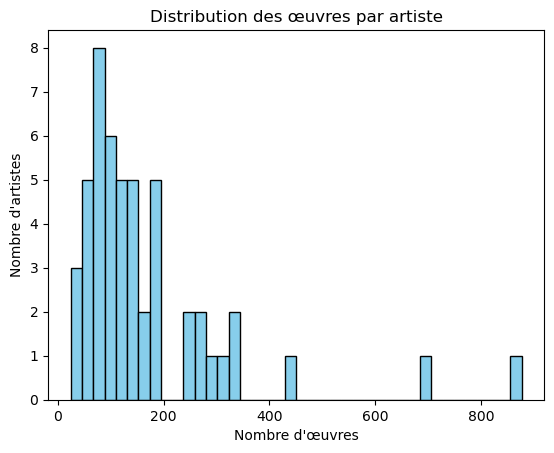

In [23]:
print("Nombre total d'artistes :", artists['name'].nunique())
print("Nombre total de styles :", artists['genre'].nunique())

artists['paintings'].plot(kind='hist', bins=40, color='skyblue', edgecolor='black')
plt.title("Distribution des œuvres par artiste")
plt.xlabel("Nombre d'œuvres")
plt.ylabel("Nombre d'artistes")
plt.show()


En dessous, on considère seulement les artistes avec moins de 200 oeuvres.

Nombre total d'artistes : 50
Nombre total de styles : 31


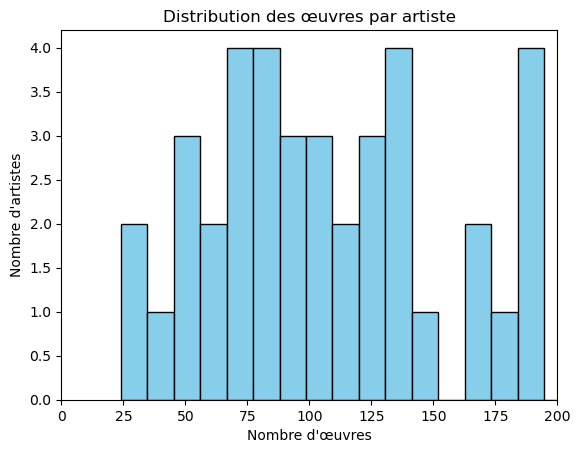

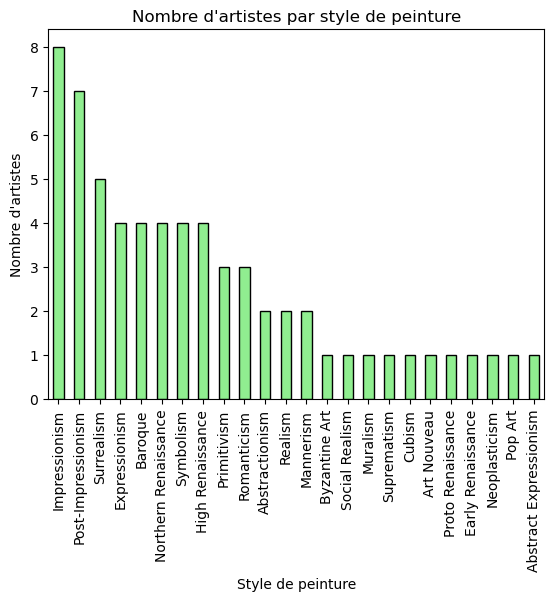

In [24]:
print("Nombre total d'artistes :", artists['name'].nunique())
print("Nombre total de styles :", artists['genre'].nunique())

artists['paintings'].plot(kind='hist', bins=80, color='skyblue', edgecolor='black')
plt.title("Distribution des œuvres par artiste")
plt.xlabel("Nombre d'œuvres")
plt.ylabel("Nombre d'artistes")
plt.xlim(0, 200)
plt.show()

styles = artists['genre'].str.split(',').explode()
style_counts = styles.value_counts()
style_counts.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title("Nombre d'artistes par style de peinture")
plt.xlabel("Style de peinture")
plt.ylabel("Nombre d'artistes")
plt.xticks(rotation=90)
plt.show()

On voit que la majorité des artistes ont un nombre d'oeuvre compris entre 100 et 200. Nous allons zoomer sur cette zone, de sorte à ce que nous puissions mieux observer les nombres d'oeuvres par artistes.



### Nombre d'oeuvres par artistes et par genre

In [25]:
artist_max = artists.loc[artists['paintings'].idxmax()]
print("Artiste avec le plus d'œuvres :")
print("Nom :", artist_max['name'])
print("Nombre d'œuvres :", artist_max['paintings'])
print("Genre :", artist_max['genre'])

artist_min = artists.loc[artists['paintings'].idxmin()]
print("\nArtiste avec le moins d'œuvres :")
print("Nom :", artist_min['name'])
print("Nombre d'œuvres :", artist_min['paintings'])
print("Genre :", artist_min['genre'])


Artiste avec le plus d'œuvres :
Nom : Vincent van Gogh
Nombre d'œuvres : 877
Genre : Post-Impressionism

Artiste avec le moins d'œuvres :
Nom : Jackson Pollock
Nombre d'œuvres : 24
Genre : Abstract Expressionism


On peut noter qu'un artiste  à plus de 800 oeuvres ( Vincent Van Gogh avec 877 oeuvres) et un artiste a 24 oeuvres (Jackson Pollock).

Nombre total d'oeuvres par genre :

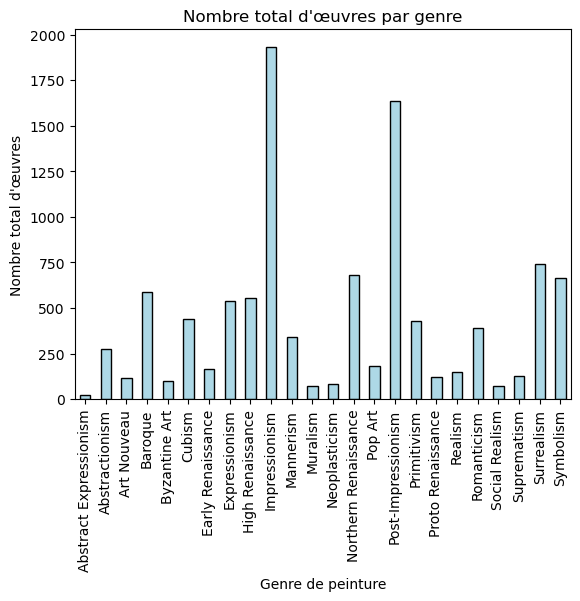

genre
Abstract Expressionism      24
Abstractionism             276
Art Nouveau                117
Baroque                    586
Byzantine Art               99
Cubism                     439
Early Renaissance          164
Expressionism              536
High Renaissance           556
Impressionism             1931
Mannerism                  342
Muralism                    70
Neoplasticism               84
Northern Renaissance       680
Pop Art                    181
Post-Impressionism        1636
Primitivism                429
Proto Renaissance          119
Realism                    149
Romanticism                388
Social Realism              70
Suprematism                126
Surrealism                 743
Symbolism                  666
Name: paintings, dtype: int64

In [26]:
genres_expanded = artists['genre'].str.split(',').explode()
expanded_data = artists.loc[genres_expanded.index, ['paintings']].assign(genre=genres_expanded.values)
genre_paintings = expanded_data.groupby('genre')['paintings'].sum()

genre_paintings.plot(kind='bar', color='lightblue', edgecolor='black')
plt.title("Nombre total d'œuvres par genre")
plt.xlabel("Genre de peinture")
plt.ylabel("Nombre total d'œuvres")
plt.xticks(rotation=90)
plt.show()

genre_paintings

En observant le nombre d'artiste par genre, on remarque que J. Pollock est le seul artiste dans sa catégorie, tandis que la catégorie de V. Van Gogh compte le plus d'artiste. De plus, en observant le nombre d'oeuvre par genre, on observe que le post impressionim compte beaucoup plus d'oeuvres que l'Expressionism. Maintenant que la distrbution des genre et des artistes est bien comprises, nous allons nous mener une analyse des périodes de vie des artistes.

### Analyse de la période de vie des artistes

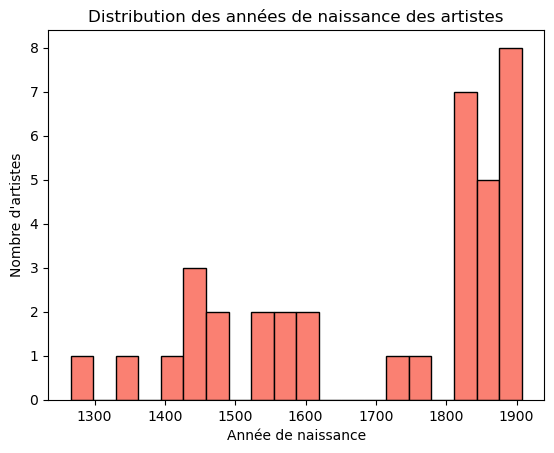

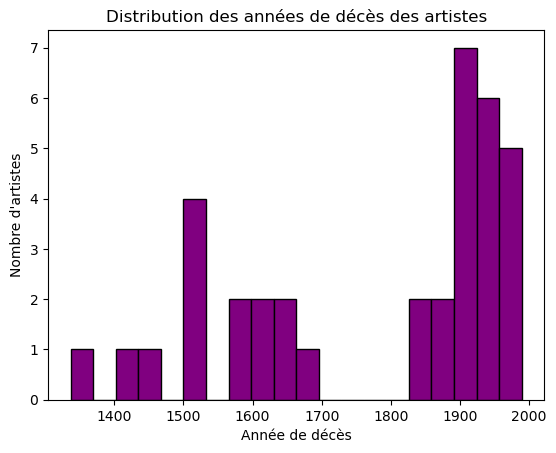

In [27]:
artists[['birth_year', 'death_year']] = artists['years'].str.split('-', expand=True)

artists['birth_year'] = pd.to_numeric(artists['birth_year'], errors='coerce')
artists['death_year'] = pd.to_numeric(artists['death_year'], errors='coerce')

artists['birth_year'].dropna().plot(kind='hist', bins=20, color='salmon', edgecolor='black')
plt.title("Distribution des années de naissance des artistes")
plt.xlabel("Année de naissance")
plt.ylabel("Nombre d'artistes")
plt.show()

artists['death_year'].dropna().plot(kind='hist', bins=20, color='purple', edgecolor='black')
plt.title("Distribution des années de décès des artistes")
plt.xlabel("Année de décès")
plt.ylabel("Nombre d'artistes")
plt.show()

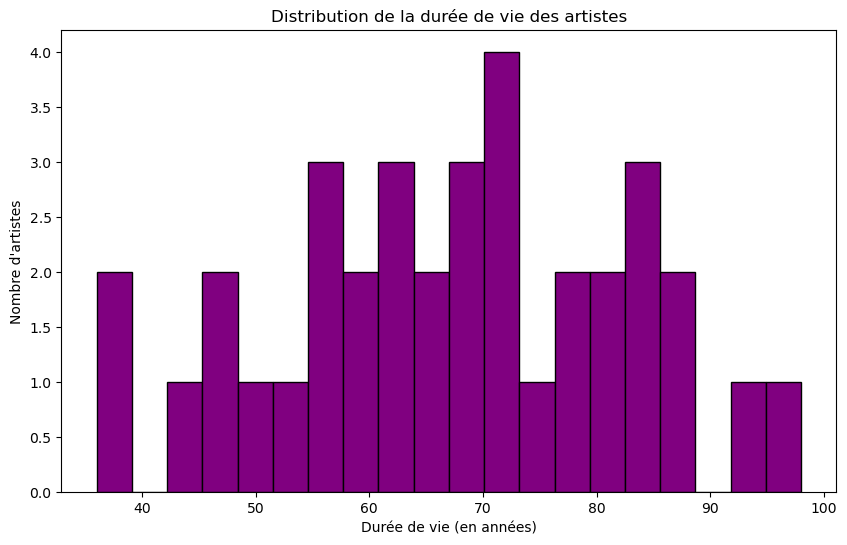

In [28]:
artists['life_duration'] = artists['death_year'] - artists['birth_year']
artists['life_duration'] = artists['life_duration'].dropna()

plt.figure(figsize=(10, 6))
artists['life_duration'].plot(kind='hist', bins=20, color='purple', edgecolor='black')
plt.title('Distribution de la durée de vie des artistes')
plt.xlabel('Durée de vie (en années)')
plt.ylabel('Nombre d\'artistes')
plt.show()

In [29]:
longest_lived_artist = artists.loc[artists['life_duration'].idxmax()]
longest_lived_name = longest_lived_artist['name']
longest_lived_paintings = longest_lived_artist['paintings']
longest_lived_duration = longest_lived_artist['life_duration']

shortest_lived_artist = artists.loc[artists['life_duration'].idxmin()]
shortest_lived_name = shortest_lived_artist['name']
shortest_lived_paintings = shortest_lived_artist['paintings']
shortest_lived_duration = shortest_lived_artist['life_duration']

print(f"Artiste avec la plus grande durée de vie : {longest_lived_name} ({longest_lived_paintings} œuvres, {longest_lived_duration} ans)")
print(f"Artiste avec la durée de vie la plus courte : {shortest_lived_name} ({shortest_lived_paintings} œuvres, {shortest_lived_duration} ans)")


Artiste avec la plus grande durée de vie : Marc Chagall (239 œuvres, 98.0 ans)
Artiste avec la durée de vie la plus courte : Amedeo Modigliani (193 œuvres, 36.0 ans)


In [30]:
correlation = artists['life_duration'].corr(artists['paintings'])
print(f"Corrélation entre durée de vie et nombre d’œuvres : {correlation}")

Corrélation entre durée de vie et nombre d’œuvres : 0.33447442133662464


Nous observons que la majorité des artistes ont émergé à partir de 1800. 

### Nationalités des artistes

Nombre d'artistes par nationalité :
nationality
French                      13
Italian                      8
Spanish                      5
Dutch                        4
Russian                      4
Flemish                      3
Mexican                      2
American                     2
Belgian                      1
Austrian                     1
Spanish,Greek                1
French,British               1
German                       1
French,Jewish,Belarusian     1
British                      1
Norwegian                    1
German,Swiss                 1
Name: count, dtype: int64


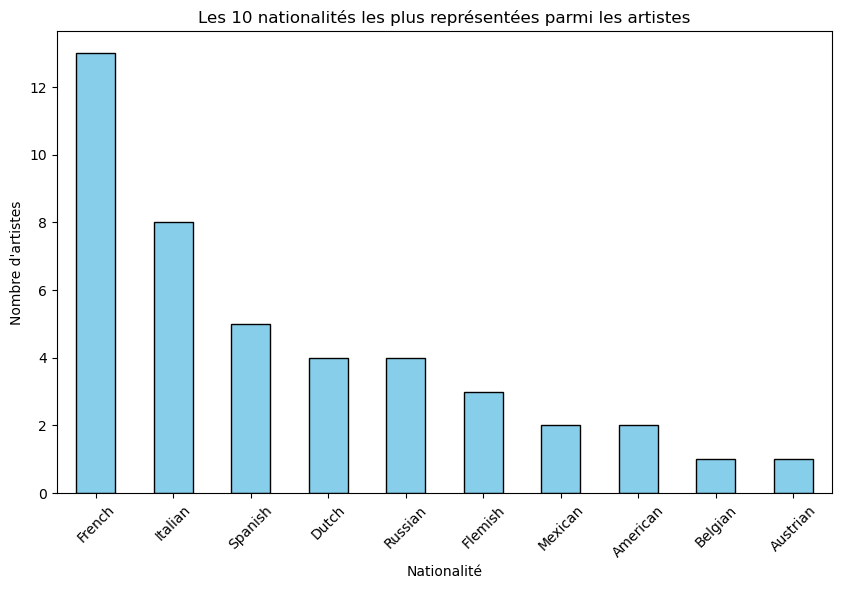

Nationalité la plus représentée : French (13 artistes)
Nationalité la moins représentée : Belgian (1 artiste(s))


In [31]:
nationality_counts = artists['nationality'].value_counts()
print("Nombre d'artistes par nationalité :")
print(nationality_counts)

top_nationalities = nationality_counts.head(10)
plt.figure(figsize=(10, 6))
top_nationalities.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Les 10 nationalités les plus représentées parmi les artistes")
plt.xlabel("Nationalité")
plt.ylabel("Nombre d'artistes")
plt.xticks(rotation=45)
plt.show()

most_represented_nationality = nationality_counts.idxmax()
least_represented_nationality = nationality_counts.idxmin()

print(f"Nationalité la plus représentée : {most_represented_nationality} ({nationality_counts.max()} artistes)")
print(f"Nationalité la moins représentée : {least_represented_nationality} ({nationality_counts.min()} artiste(s))")


On remarque que certains peintres ont plusieurs nationalités:
- Spanish,Greek
- French,British
- French,Jewish,Belarusian
- German,Swiss

De ce fait, une personne étant en française et anglaise, sera comptée dans une catégorie distincte, ici "French,British". Dans l'optique de corriger cela, nous avons dans la cellule suivante compté les personnes ayant des nationalités différentes, dans les catégories associées à chacune de leurs nationalités. Une personne française et anglaise sera donc compté dans la catégorie française ainsi que la catégorie anglaise.

Nombre d'artistes par nationalité :
nationality
French        15
Italian        8
Spanish        6
Dutch          4
Russian        4
Flemish        3
Mexican        2
British        2
German         2
American       2
Belgian        1
Austrian       1
Greek          1
Jewish         1
Belarusian     1
Norwegian      1
Swiss          1
Name: count, dtype: int64


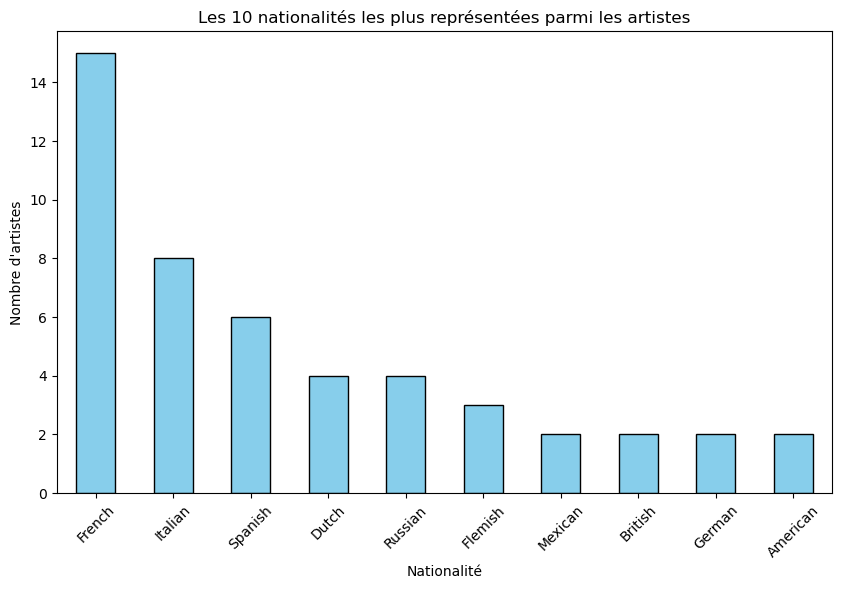

Nationalité la plus représentée : French (15 artistes)
Nationalité les moins représentées : ['Belgian', 'Austrian', 'Greek', 'Jewish', 'Belarusian', 'Norwegian', 'Swiss'] (1 artiste(s))


In [32]:
expanded_nationalities = artists['nationality'].str.split(',').explode()
nationality_counts = expanded_nationalities.value_counts()

print("Nombre d'artistes par nationalité :")
print(nationality_counts)

top_nationalities = nationality_counts.head(10)
plt.figure(figsize=(10, 6))
top_nationalities.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Les 10 nationalités les plus représentées parmi les artistes")
plt.xlabel("Nationalité")
plt.ylabel("Nombre d'artistes")
plt.xticks(rotation=45)
plt.show()

most_represented_nationality = nationality_counts.idxmax()
least_represented_count = nationality_counts.min()
least_represented_nationalities = nationality_counts[nationality_counts == least_represented_count].index.tolist()


print(f"Nationalité la plus représentée : {most_represented_nationality} ({nationality_counts.max()} artistes)")
print(f"Nationalité les moins représentées : {least_represented_nationalities} ({nationality_counts.min()} artiste(s))")


Nombre d'œuvres par pays :
nationality
French                      2120
Dutch                       1360
Spanish                     1099
Italian                     1087
Russian                      484
Flemish                      356
German                       328
French,British               259
French,Jewish,Belarusian     239
American                     205
Belgian                      194
Mexican                      190
German,Swiss                 188
Austrian                     117
Spanish,Greek                 87
Norwegian                     67
British                       66
Name: paintings, dtype: int64


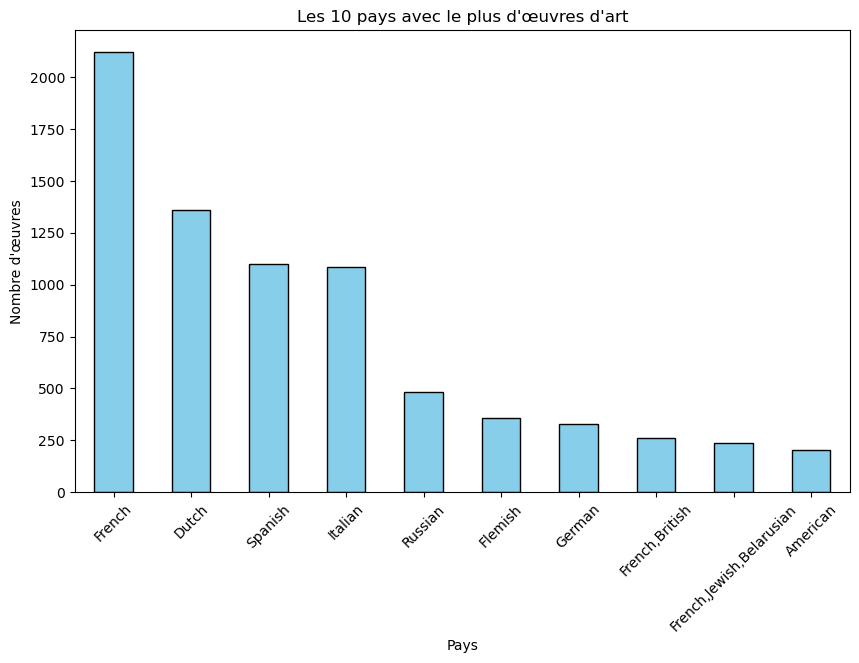

Pays avec le plus d'œuvres : French (2120 œuvres)
Pays avec le moins d'œuvres : British (66 œuvre(s))


In [33]:
country_paintings = artists.groupby('nationality')['paintings'].sum().sort_values(ascending=False)

print("Nombre d'œuvres par pays :")
print(country_paintings)

top_countries = country_paintings.head(10)
plt.figure(figsize=(10, 6))
top_countries.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Les 10 pays avec le plus d'œuvres d'art")
plt.xlabel("Pays")
plt.ylabel("Nombre d'œuvres")
plt.xticks(rotation=45)
plt.show()

most_paintings_country = country_paintings.idxmax()
least_paintings_country = country_paintings.idxmin()

print(f"Pays avec le plus d'œuvres : {most_paintings_country} ({country_paintings.max()} œuvres)")
print(f"Pays avec le moins d'œuvres : {least_paintings_country} ({country_paintings.min()} œuvre(s))")

Nous observons que la majorité des artistes sont français ou italien, tandis que les artistes les moins nombeux sont orginaires de Belgique, d'Autriche, ...
En outre, nous observons que la France est le pays contenant le plus d'oeuvres, suivi de l'Allemagne. L'Italie arrive en 4ème position, alors qu'elle compte deux fois plus d'artistes que l'Allemagne (4 artistes). Cela nous montre qu'un nombre plus élevé d'artiste dans un pays n'implique pas forcément un plus grand nombre d'oeuvres produites par ces artistes.

## Global params

In [34]:
BATCH_SIZE = 32
EPOCHS = 3
CHANNELS = 3

IMAGE_HQ_SIZE = 224
IMAGE_LQ_SIZE = 64
MEAN_HQ = [0.485, 0.456, 0.406]
STD_HQ = [0.229, 0.224, 0.225]
TRANSFORM_HQ = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),  # Interpolate
    #transforms.Pad((32, 32, 32, 32)),  # Padding
    transforms.CenterCrop(224),  # Center
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN_HQ, std=STD_HQ)
])


def load_image_as_rgb_matrices(image_name):    
    img = Image.open(images_lq_path + image_name)
    img = img.resize((IMAGE_LQ_SIZE, IMAGE_LQ_SIZE))  
    img = img.convert('RGB')
    return np.array(img)

## Creating LQ images loaders

Dans cette partie, nous allons nous intéréesser au dossier `images_lq` contenant toutes les peintures, classées par artistes, en basse résolution.

In [7]:
images_lq_path = data_path + "images_lq/"
images_filename = os.listdir(images_lq_path)

list_name = []

for filename in images_filename:
    parts = filename.split('_')
    if len(parts) > 3:
        name_surname = f"{parts[0]} {parts[1]} {parts[2]}"
    elif len(parts) == 3:
        name_surname = f"{parts[0]} {parts[1]}"
    elif len(parts) == 2:  # "Name_xxx" format
        name_surname = parts[0]  # Only Name
    list_name.append(name_surname)

In [8]:
if len(images_filename) == len(list_name):
    total_lq_df = pd.DataFrame({
        'filename': images_filename,
        'artist': list_name,
    })
    print("DataFrame created successfully!")
else:
    print("Error: The lists have different lengths.")

DataFrame created successfully!


### Dataloaders avec tous les artistes

In [9]:
IMAGE_LQ_SIZE = 64
DATASET_LQ_SIZE = len(images_filename)
CHANNELS = 3

x = np.zeros((DATASET_LQ_SIZE, IMAGE_LQ_SIZE, IMAGE_LQ_SIZE, CHANNELS))
for i in range(DATASET_LQ_SIZE):
    x[i] = load_image_as_rgb_matrices(images_filename[i])

In [10]:
classes = np.array(list(set(total_lq_df['artist'])))
classes_as_int = np.array([np.where(classes == artist)[0][0] for artist in total_lq_df['artist']])

x_train, x_test_val, y_train, y_test_val = train_test_split(
    np.transpose(x, (0, 3, 1, 2)),  classes_as_int, test_size=0.2, random_state=42
)

x_test, x_val, y_test, y_val = train_test_split(
    x_test_val, y_test_val, test_size=0.5, random_state=42
)

# Normalize images
x_train, x_val, x_test = x_train / 255.0, x_val / 255.0, x_test / 255.0

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset_lq = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset_lq = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset_lq = TensorDataset(x_test_tensor, y_test_tensor)

train_loader_lq = DataLoader(train_dataset_lq, batch_size=BATCH_SIZE, shuffle=True)
val_loader_lq = DataLoader(val_dataset_lq, batch_size=BATCH_SIZE, shuffle=True)
test_loader_lq = DataLoader(test_dataset_lq, batch_size=1, shuffle=False)

print(f"Train dataset size: {len(train_dataset_lq)}")
print(f"Validation dataset size: {len(val_dataset_lq)}")
print(f"Test dataset size: {len(test_dataset_lq)}")

Train dataset size: 6684
Validation dataset size: 836
Test dataset size: 835


### Dataloaders avec les artistes ayant plus de 85 oeuvres

In [11]:
artist_counts_lq = Counter(total_lq_df['artist'])

print("Nombre d'artistes :", len(artist_counts_lq))

print("\nNombre d'oeuvres pour chaque artiste du dataset LQ :")
for artist, count in artist_counts_lq.items():
    print(f"{artist}: {count} oeuvres")

Nombre d'artistes : 50

Nombre d'oeuvres pour chaque artiste du dataset LQ :
Albrecht Dürer: 328 oeuvres
Alfred Sisley: 259 oeuvres
Amedeo Modigliani: 193 oeuvres
Andrei Rublev: 99 oeuvres
Andy Warhol: 181 oeuvres
Camille Pissarro: 91 oeuvres
Caravaggio: 55 oeuvres
Claude Monet: 73 oeuvres
Diego Rivera: 70 oeuvres
Diego Velazquez: 37 oeuvres
Edgar Degas: 702 oeuvres
Edouard Manet: 90 oeuvres
Edvard Munch: 67 oeuvres
El Greco: 87 oeuvres
Eugene Delacroix: 31 oeuvres
Francisco Goya: 291 oeuvres
Frida Kahlo: 120 oeuvres
Georges Seurat: 43 oeuvres
Giotto di Bondone: 119 oeuvres
Gustave Courbet: 59 oeuvres
Gustav Klimt: 117 oeuvres
Henri de Toulouse-Lautrec: 81 oeuvres
Henri Matisse: 186 oeuvres
Henri Rousseau: 70 oeuvres
Hieronymus Bosch: 137 oeuvres
Jackson Pollock: 24 oeuvres
Jan van Eyck: 81 oeuvres
Joan Miro: 102 oeuvres
Kazimir Malevich: 126 oeuvres
Leonardo da Vinci: 143 oeuvres
Marc Chagall: 239 oeuvres
Michelangelo: 49 oeuvres
Mikhail Vrubel: 171 oeuvres
Pablo Picasso: 439 oeuvres


On remarque qu'un certain nombre d'artistes ont réalisé peu d'oeuvres. Dans la partie suivante, on décide de supprimer du dataframe les artistes avec moins de 85 oeuvres réaliser pour éviter qu'ils aient un impact négatif sur l'entrainement.

In [12]:
artist_counts_lq = Counter(total_lq_df['artist'])

artists_with_more_than_85_lq = {
    artist: count for artist, count in artist_counts_lq.items() if count > 85
}

artists_list_lq = list(artists_with_more_than_85_lq.keys())

print("Nombre d'artistes avec plus de 85 oeuvres :", len(artists_with_more_than_85_lq))

print("\nArtistes avec plus de 85 oeuvres dans les images LQ :")
for artist, count in artists_with_more_than_85_lq.items():
    print(f"{artist}: {count} oeuvres")

Nombre d'artistes avec plus de 85 oeuvres : 34

Artistes avec plus de 85 oeuvres dans les images LQ :
Albrecht Dürer: 328 oeuvres
Alfred Sisley: 259 oeuvres
Amedeo Modigliani: 193 oeuvres
Andrei Rublev: 99 oeuvres
Andy Warhol: 181 oeuvres
Camille Pissarro: 91 oeuvres
Edgar Degas: 702 oeuvres
Edouard Manet: 90 oeuvres
El Greco: 87 oeuvres
Francisco Goya: 291 oeuvres
Frida Kahlo: 120 oeuvres
Giotto di Bondone: 119 oeuvres
Gustav Klimt: 117 oeuvres
Henri Matisse: 186 oeuvres
Hieronymus Bosch: 137 oeuvres
Joan Miro: 102 oeuvres
Kazimir Malevich: 126 oeuvres
Leonardo da Vinci: 143 oeuvres
Marc Chagall: 239 oeuvres
Mikhail Vrubel: 171 oeuvres
Pablo Picasso: 439 oeuvres
Paul Gauguin: 311 oeuvres
Paul Klee: 188 oeuvres
Peter Paul Rubens: 141 oeuvres
Pierre-Auguste Renoir: 336 oeuvres
Pieter Bruegel: 134 oeuvres
Raphael: 109 oeuvres
Rembrandt: 262 oeuvres
Rene Magritte: 194 oeuvres
Salvador Dali: 139 oeuvres
Sandro Botticelli: 164 oeuvres
Titian: 255 oeuvres
Vasiliy Kandinskiy: 88 oeuvres
Vince

In [13]:
total_lq_filtered = total_lq_df[total_lq_df['artist'].isin(artists_list_lq)].copy()

images_filename_filtered = total_lq_filtered['filename'].tolist()

DATASET_LQ_SIZE = len(images_filename_filtered)
print(f"Nombre total d'images après filtrage : {DATASET_LQ_SIZE}")

Nombre total d'images après filtrage : 7418


In [14]:
x_filtered = np.zeros((DATASET_LQ_SIZE, IMAGE_LQ_SIZE, IMAGE_LQ_SIZE, CHANNELS))

for i, filename in enumerate(images_filename_filtered):
    x_filtered[i] = load_image_as_rgb_matrices(filename)
    
classes_filtered = np.array(list(set(total_lq_filtered['artist'])))
classes_as_int_filtered = np.array([
    np.where(classes_filtered == artist)[0][0] for artist in total_lq_filtered['artist']
])

x_train, x_test_val, y_train, y_test_val = train_test_split(
    np.transpose(x_filtered, (0, 3, 1, 2)),  
    classes_as_int_filtered, 
    test_size=0.2, 
    random_state=42
)

x_test, x_val, y_test, y_val = train_test_split(
    x_test_val, 
    y_test_val, 
    test_size=0.5, 
    random_state=42
)

x_train, x_val, x_test = x_train / 255.0, x_val / 255.0, x_test / 255.0


x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset_lq = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset_lq = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset_lq = TensorDataset(x_test_tensor, y_test_tensor)

train_loader_lq = DataLoader(train_dataset_lq, batch_size=BATCH_SIZE, shuffle=True)
val_loader_lq = DataLoader(val_dataset_lq, batch_size=BATCH_SIZE, shuffle=True)
test_loader_lq = DataLoader(test_dataset_lq, batch_size=1, shuffle=False)

print(f"Train dataset size: {len(train_dataset_lq)}")
print(f"Validation dataset size: {len(val_dataset_lq)}")
print(f"Test dataset size: {len(test_dataset_lq)}")


Train dataset size: 5934
Validation dataset size: 742
Test dataset size: 742


### Plots de quelques oeuvres

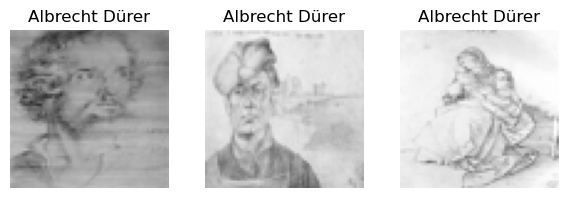

In [33]:
number_of_plots = 3
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(number_of_plots * 2, 2))

for i in range(number_of_plots):
    axes[i].imshow(x[i*100]/255.0)
    axes[i].axis('off')
    axes[i].set_title(f"{list_name[i*100]}")
    
plt.tight_layout()
plt.show()

## Creating HQ images loaders

In [15]:
gc = "./art-challenge/images_hq"
dataset_hq = datasets.ImageFolder(root=gc, transform=TRANSFORM_HQ)
DATASET_HQ_SIZE = len(dataset_hq)
CLASS_TO_IDX_HQ = dataset_hq.class_to_idx
IDX_TO_CLASS_HQ = {idx: name for name, idx in CLASS_TO_IDX_HQ.items()}

In [16]:
CLASS_TO_IDX_HQ = {key.replace('_', ' '): value for key, value in CLASS_TO_IDX_HQ.items()}

### Dataloaders avec tous les artistes

In [36]:
train_size = int(0.8 * DATASET_HQ_SIZE)
val_size = int(0.1 * DATASET_HQ_SIZE)
test_size = DATASET_HQ_SIZE - train_size - val_size

train_dataset_hq, val_dataset_hq, test_dataset_hq = random_split(dataset_hq, [train_size, val_size, test_size])

train_loader_hq = DataLoader(train_dataset_hq, batch_size=BATCH_SIZE, shuffle=True)
val_loader_hq = DataLoader(val_dataset_hq, batch_size=BATCH_SIZE, shuffle=True)
test_loader_hq = DataLoader(test_dataset_hq, batch_size=1, shuffle=False)

print(f"Train dataset size: {len(train_dataset_hq)}")
print(f"Validation dataset size: {len(val_dataset_hq)}")
print(f"Test dataset size: {len(test_dataset_hq)}")

Train dataset size: 6756
Validation dataset size: 844
Test dataset size: 846


On remarque une différence du nombre d'oeuvres entre les dataloaders HQ et LQ.

In [43]:
list_of_artists_hq = list(CLASS_TO_IDX_HQ.keys())

print("Nombre d'artistes :", len(list_of_artists_hq))

print("\nListe des artistes dans le dataset HQ:")
for artist in list_of_artists_hq:
    print(artist)

Nombre d'artistes : 50

Liste des artistes dans le dataset HQ:
Albrecht Dürer
Alfred Sisley
Amedeo Modigliani
Andrei Rublev
Andy Warhol
Camille Pissarro
Caravaggio
Claude Monet
Diego Rivera
Diego Velazquez
Edgar Degas
Edouard Manet
Edvard Munch
El Greco
Eugene Delacroix
Francisco Goya
Frida Kahlo
Georges Seurat
Giotto di Bondone
Gustav Klimt
Gustave Courbet
Henri Matisse
Henri Rousseau
Henri de Toulouse-Lautrec
Hieronymus Bosch
Jackson Pollock
Jan van Eyck
Joan Miro
Kazimir Malevich
Leonardo da Vinci
Marc Chagall
Michelangelo
Mikhail Vrubel
Pablo Picasso
Paul Cezanne
Paul Gauguin
Paul Klee
Peter Paul Rubens
Pierre-Auguste Renoir
Piet Mondrian
Pieter Bruegel
Raphael
Rembrandt
Rene Magritte
Salvador Dali
Sandro Botticelli
Titian
Vasiliy Kandinskiy
Vincent van Gogh
William Turner


Le nombre d'artistes est identiques entre LQ et HQ. La différence en nombre d'oeuvres ne vient donc pas de là. Nous allons nous interessé au nombre d'oeuvres par artistes.

In [44]:
print("Nombre d'œuvres pour chaque artiste dans le dataset HQ :")
for artist in list_of_artists_hq:
    if artist in artists['name'].values:
        num_paintings = artists.loc[artists['name'] == artist, 'paintings'].values[0]
        print(f"{artist}: {num_paintings} œuvres")
    else:
        print(f"{artist}: Nombre d'œuvres inconnu")

Nombre d'œuvres pour chaque artiste dans le dataset HQ :
Albrecht Dürer: 328 œuvres
Alfred Sisley: 259 œuvres
Amedeo Modigliani: 193 œuvres
Andrei Rublev: 99 œuvres
Andy Warhol: 181 œuvres
Camille Pissarro: 91 œuvres
Caravaggio: 55 œuvres
Claude Monet: 73 œuvres
Diego Rivera: 70 œuvres
Diego Velazquez: 128 œuvres
Edgar Degas: 702 œuvres
Edouard Manet: 90 œuvres
Edvard Munch: 67 œuvres
El Greco: 87 œuvres
Eugene Delacroix: 31 œuvres
Francisco Goya: 291 œuvres
Frida Kahlo: 120 œuvres
Georges Seurat: 43 œuvres
Giotto di Bondone: 119 œuvres
Gustav Klimt: 117 œuvres
Gustave Courbet: 59 œuvres
Henri Matisse: 186 œuvres
Henri Rousseau: 70 œuvres
Henri de Toulouse-Lautrec: 81 œuvres
Hieronymus Bosch: 137 œuvres
Jackson Pollock: 24 œuvres
Jan van Eyck: 81 œuvres
Joan Miro: 102 œuvres
Kazimir Malevich: 126 œuvres
Leonardo da Vinci: 143 œuvres
Marc Chagall: 239 œuvres
Michelangelo: 49 œuvres
Mikhail Vrubel: 171 œuvres
Pablo Picasso: 439 œuvres
Paul Cezanne: 47 œuvres
Paul Gauguin: 311 œuvres
Paul

In [100]:
print("Artiste(s) n'ayant pas le même nombre d'oeuvres LQ et HQ :")
for i in range(len(list_of_artists_hq)):
    count_hq = artists.loc[artists['name'] == list_of_artists_hq[i], 'paintings'].values[0]
    count_lq = artist_counts_lq.get(list_of_artists_hq[i])
    if (count_hq - count_lq !=0):
        print(list_of_artists_hq[i],": Image LQ =",count_lq,",Image HQ =", count_hq)

Artiste(s) n'ayant pas le même nombre d'oeuvres LQ et HQ :
Diego Velazquez : Image LQ = 37 ,Image HQ = 128


### Dataloaders avec les artistes ayant plus de 85 oeuvres

In [41]:
artists_filtered = artists.loc[artists['paintings'] > 85, 'name']

artists_list = artists_filtered.tolist()

print("Nombre d'artistes :", len(artists_list))

print("\nArtistes avec plus de 85 œuvres :")
for artist in artists_list:
    print(artist)

Nombre d'artistes : 35

Artistes avec plus de 85 œuvres :
Amedeo Modigliani
Vasiliy Kandinskiy
Rene Magritte
Salvador Dali
Edouard Manet
Andrei Rublev
Vincent van Gogh
Gustav Klimt
Hieronymus Bosch
Kazimir Malevich
Mikhail Vrubel
Pablo Picasso
Peter Paul Rubens
Pierre-Auguste Renoir
Francisco Goya
Frida Kahlo
El Greco
Albrecht Dürer
Alfred Sisley
Pieter Bruegel
Marc Chagall
Giotto di Bondone
Sandro Botticelli
Leonardo da Vinci
Diego Velazquez
Henri Matisse
Edgar Degas
Rembrandt
Titian
Camille Pissarro
Paul Klee
Joan Miro
Andy Warhol
Paul Gauguin
Raphael


In [102]:
gc = "./art-challenge/images_hq"
dataset_hq = datasets.ImageFolder(root=gc, transform=TRANSFORM_HQ)
DATASET_HQ_SIZE = len(dataset_hq)
CLASS_TO_IDX_HQ = dataset_hq.class_to_idx
IDX_TO_CLASS_HQ = {idx: name for name, idx in CLASS_TO_IDX_HQ.items()}


artist_counts = Counter()
for _, label in dataset_hq:
    artist = IDX_TO_CLASS_HQ[label]
    artist_counts[artist] += 1


artists_with_more_than_85 = {artist: count for artist, count in artist_counts.items() if count > 85}
print("Artistes avec plus de 85 occurrences :")
for artist, count in artists_with_more_than_85.items():
    print(f"{artist}: {count} occurrences")


hq_class_to_new_idx = {artist: idx for idx, artist in enumerate(artists_with_more_than_85)}
hq_idx_to_class = {idx: artist for artist, idx in hq_class_to_new_idx.items()}


hq_indices = [CLASS_TO_IDX_HQ[artist] for artist in artists_with_more_than_85 if artist in CLASS_TO_IDX_HQ]


filtered_hq_dataset = [data for data in dataset_hq if data[1] in hq_indices]


filtered_hq_dataset = [(data[0], hq_class_to_new_idx[IDX_TO_CLASS_HQ[data[1]]]) for data in filtered_hq_dataset]


train_size = int(0.8 * len(filtered_hq_dataset))
val_size = int(0.1 * len(filtered_hq_dataset))
test_size = len(filtered_hq_dataset) - train_size - val_size

train_dataset_hq, val_dataset_hq, test_dataset_hq = random_split(
    filtered_hq_dataset, [train_size, val_size, test_size]
)


train_loader_hq = DataLoader(train_dataset_hq, batch_size=BATCH_SIZE, shuffle=True)
val_loader_hq = DataLoader(val_dataset_hq, batch_size=BATCH_SIZE, shuffle=True)
test_loader_hq = DataLoader(test_dataset_hq, batch_size=1, shuffle=False)


print(f"Train dataset size: {len(train_dataset_hq)}")
print(f"Validation dataset size: {len(val_dataset_hq)}")
print(f"Test dataset size: {len(test_dataset_hq)}")

Artistes avec plus de 85 occurrences :
Albrecht_Dürer: 328 occurrences
Alfred_Sisley: 259 occurrences
Amedeo_Modigliani: 193 occurrences
Andrei_Rublev: 99 occurrences
Andy_Warhol: 181 occurrences
Camille_Pissarro: 91 occurrences
Diego_Velazquez: 128 occurrences
Edgar_Degas: 702 occurrences
Edouard_Manet: 90 occurrences
El_Greco: 87 occurrences
Francisco_Goya: 291 occurrences
Frida_Kahlo: 120 occurrences
Giotto_di_Bondone: 119 occurrences
Gustav_Klimt: 117 occurrences
Henri_Matisse: 186 occurrences
Hieronymus_Bosch: 137 occurrences
Joan_Miro: 102 occurrences
Kazimir_Malevich: 126 occurrences
Leonardo_da_Vinci: 143 occurrences
Marc_Chagall: 239 occurrences
Mikhail_Vrubel: 171 occurrences
Pablo_Picasso: 439 occurrences
Paul_Gauguin: 311 occurrences
Paul_Klee: 188 occurrences
Peter_Paul_Rubens: 141 occurrences
Pierre-Auguste_Renoir: 336 occurrences
Pieter_Bruegel: 134 occurrences
Raphael: 109 occurrences
Rembrandt: 262 occurrences
Rene_Magritte: 194 occurrences
Salvador_Dali: 139 occurrenc

## Training et optimisation

### Fonctions `train` et `test`

In [107]:
def train(model, criterion, optimizer, train_loader, val_loader, epochs=EPOCHS, save_model=False, model_path=MODEL_PATH):
    # Training of the model
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        total_train_samples = 0
        correct_train = 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            
            # FB
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # BW
            loss.backward()
            optimizer.step()
            
            # Do not need to apply softmax manually -> this order will be the same
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()

            train_loss += loss.item()
            total_train_samples += images.size(0)
        
        train_loss = train_loss / total_train_samples
        train_accuracy = correct_train / total_train_samples

        # Validation
        model.eval()
        val_loss = 0.0
        total_val_samples = 0
        correct_val = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader):
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                total_val_samples += images.size(0)
                
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
        
        val_loss = val_loss / total_val_samples
        val_accuracy = correct_val / total_val_samples
        
        # Train accuracy could be used to check if the network learns something
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    if save_model:
        torch.save(model.state_dict(), model_path)    

In [108]:
def test(test_loader, model_path=MODEL_PATH):
    model = get_model(weights=None)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model = model.to(DEVICE)

    # Validation
    model.eval()
    test_loss = 0.0
    total_test_samples = 0
    correct_test = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
                
            outputs = model(images)
            loss = criterion(outputs, labels)
                
            test_loss += loss.item()
            total_test_samples += images.size(0)
                
            _, preds = torch.max(outputs, 1)
            correct_test += (preds == labels).sum().item()
        
        test_loss = test_loss / total_test_samples
        test_accuracy = correct_test / total_test_samples

        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return test_loss, test_accuracy

### ResNet18

In [109]:
#NUM_CLASSES = len(dataset_hq.classes) # Same value for lQ dataset
NUM_CLASSES = len(artists_with_more_than_85)
DROPOUT_RATE = 0.4
MODEL_PATH = "cnn_weights.pth"

def get_model(name='resnet18', weights='IMAGENET1K_V1', verbose=False):
    model = getattr(models, name)(weights=weights)
    model.fc = nn.Sequential(
        nn.Dropout(p=DROPOUT_RATE),                  
        nn.Linear(model.fc.in_features, NUM_CLASSES)
    ) 

    if verbose:
        trainable_params =  sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f'Trainable params: {trainable_params}')
        
    return model

In [111]:
# Define the model
model = get_model()
model = model.to(DEVICE)

# The best values found previously
fc_lr = 6.47e-4  
base_lr = 8.587e-5
# Assure-toi que NUM_CLASSES est mis à jour avec les artistes filtrés
NUM_CLASSES = len(artists_with_more_than_85)  # Nombre de classes après filtrage


base_params = [p for name, p in model.named_parameters() if "fc" not in name]    
# Init optimizer
optimizer = optim.Adam([
    {'params': model.fc.parameters(), 'lr': fc_lr},      # LR for fully connected layer
    {'params': base_params, 'lr': base_lr}               # LR for pretrained layers
])

# Loss
criterion = nn.CrossEntropyLoss(reduction='sum')
#criterion = FocalLoss(alpha=alpha.to(DEVICE), gamma=2, reduction='mean')

train(model, criterion, optimizer, train_loader_hq, val_loader_hq, epochs=10, save_model=True)

100%|█████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 108.11it/s]


Epoch 1/10, Train Loss: 1.9728, Train Accuracy: 0.4722, Val Loss: 1.1423, Val Accuracy: 0.6684


100%|█████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 107.14it/s]


Epoch 2/10, Train Loss: 0.8094, Train Accuracy: 0.7767, Val Loss: 0.9091, Val Accuracy: 0.7294


100%|█████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 109.57it/s]


Epoch 3/10, Train Loss: 0.3446, Train Accuracy: 0.9173, Val Loss: 0.7546, Val Accuracy: 0.7719


100%|█████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 109.59it/s]


Epoch 4/10, Train Loss: 0.1427, Train Accuracy: 0.9710, Val Loss: 0.6949, Val Accuracy: 0.7891


100%|█████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 103.45it/s]


Epoch 5/10, Train Loss: 0.0638, Train Accuracy: 0.9929, Val Loss: 0.7203, Val Accuracy: 0.7891


100%|█████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 107.14it/s]


Epoch 6/10, Train Loss: 0.0483, Train Accuracy: 0.9911, Val Loss: 0.6877, Val Accuracy: 0.7971


100%|█████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 100.42it/s]


Epoch 7/10, Train Loss: 0.0343, Train Accuracy: 0.9952, Val Loss: 0.6875, Val Accuracy: 0.8050


100%|█████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 102.56it/s]


Epoch 8/10, Train Loss: 0.0241, Train Accuracy: 0.9973, Val Loss: 0.7366, Val Accuracy: 0.7984


100%|█████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 109.09it/s]


Epoch 9/10, Train Loss: 0.0281, Train Accuracy: 0.9954, Val Loss: 0.8351, Val Accuracy: 0.7745


100%|█████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 108.11it/s]

Epoch 10/10, Train Loss: 0.0280, Train Accuracy: 0.9947, Val Loss: 0.9420, Val Accuracy: 0.7493


In [112]:
loss, acc = test(test_loader_hq)

C:\Users\damie\AppData\Local\Temp\ipykernel_17528\3283778341.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=DE

Test Loss: 1.0230, Test Accuracy: 0.7619


On constate une convergence des accuracy d'entrainement et de validation dès la 5e itération. Le modèle a toutefois tendance à overfitter, avec une `train accuracy` de 0.99 mais une `val accuracy` = 0.79 et une `test accuracy` = 0.76.

### Optuna

In [ ]:
# Here we use Optuna to optimize the best hyper-params
# Long time execution...
# See https://github.com/optuna/optuna-examples/blob/main/pytorch/pytorch_simple.py
def objective(trial):
    # Define the model
    model = get_model()
    model = model.to(DEVICE)

    # The different parameters we're trying to improve
    fc_lr = trial.suggest_float("fc_lr", 1e-4, 1e-2, log=True)  
    base_lr = trial.suggest_float("base_lr", 1e-6, 1e-4, log=True)

    base_params = [p for name, p in model.named_parameters() if "fc" not in name]    
    # Init optimizer
    optimizer = optim.Adam([
        {'params': model.fc.parameters(), 'lr': fc_lr},      # LR for fully connected layer
        {'params': base_params, 'lr': base_lr}               # LR for pretrained layers
    ])

    # Loss
    criterion = nn.CrossEntropyLoss(reduction='sum')
    #criterion = FocalLoss(alpha=alpha.to(DEVICE), gamma=2, reduction='mean')
    
    train(model, criterion, optimizer, train_loader_hq, val_loader_hq)
    
    trial.report(val_accuracy, epoch)

    # Handle pruning based on the intermediate value.
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return val_accuracy

In [ ]:
# Default sampler used: https://optuna.readthedocs.io/en/stable/reference/samplers/generated/optuna.samplers.TPESampler.html
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

### EfficientNet

EfficientNet existe en plusieurs versions:
- EfficientNet_Bx (x $ \in [0:7]$) : Précision, durée de calcul, profondeur de réseau et résolution augmentent avec x
- EfficientNet_V2_t (t $ \in $ [s,l,m]) : Version améliorée de EfficientNet_Bx, existe en 3 versions : Small, Medium et Large

In [113]:
#La fonction get_model est redéfinie car EfficientNet ne possède pas de fully connected layer (.fc pour ResNet)

def get_model(name='efficientnet_v2_s', weights='IMAGENET1K_V1', verbose=False):
    model = getattr(models, name)(weights=weights)
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, NUM_CLASSES)

    if verbose:
        trainable_params =  sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f'Trainable params: {trainable_params}')
        
    return model

#### Small

In [114]:
model = get_model(name='efficientnet_v2_s')
model = model.to(DEVICE)

fc_lr = 6.47e-4  
base_lr = 8.587e-5
# Assure-toi que NUM_CLASSES est mis à jour avec les artistes filtrés
NUM_CLASSES = len(artists_with_more_than_85)  # Nombre de classes après filtrage


base_params = [p for name, p in model.named_parameters() if "classifier.1" not in name]    
# Init optimizer
optimizer = optim.Adam([
    {'params': model.classifier[1].parameters(), 'lr': fc_lr},      # LR for fully connected layer
    {'params': base_params, 'lr': base_lr}               # LR for pretrained layers
])

# Loss
criterion = nn.CrossEntropyLoss(reduction='sum')
#criterion = FocalLoss(alpha=alpha.to(DEVICE), gamma=2, reduction='mean')

train(model, criterion, optimizer, train_loader_hq, val_loader_hq, epochs=10, save_model=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 29.38it/s]


Epoch 1/10, Train Loss: 2.0955, Train Accuracy: 0.4389, Val Loss: 1.1030, Val Accuracy: 0.7003


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 32.61it/s]


Epoch 2/10, Train Loss: 0.7037, Train Accuracy: 0.8010, Val Loss: 0.7348, Val Accuracy: 0.7851


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 31.29it/s]


Epoch 3/10, Train Loss: 0.2553, Train Accuracy: 0.9321, Val Loss: 0.6020, Val Accuracy: 0.8223


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 33.66it/s]


Epoch 4/10, Train Loss: 0.1058, Train Accuracy: 0.9755, Val Loss: 0.6132, Val Accuracy: 0.8156


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 34.48it/s]


Epoch 5/10, Train Loss: 0.0580, Train Accuracy: 0.9861, Val Loss: 0.6098, Val Accuracy: 0.8342


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 34.73it/s]


Epoch 6/10, Train Loss: 0.0449, Train Accuracy: 0.9889, Val Loss: 0.6409, Val Accuracy: 0.8156


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 34.33it/s]


Epoch 7/10, Train Loss: 0.0419, Train Accuracy: 0.9882, Val Loss: 0.6513, Val Accuracy: 0.8249


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 33.29it/s]


Epoch 8/10, Train Loss: 0.0381, Train Accuracy: 0.9891, Val Loss: 0.6744, Val Accuracy: 0.8210


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 33.85it/s]


Epoch 9/10, Train Loss: 0.0289, Train Accuracy: 0.9927, Val Loss: 0.7129, Val Accuracy: 0.8276


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 33.85it/s]


Epoch 10/10, Train Loss: 0.0318, Train Accuracy: 0.9907, Val Loss: 0.7035, Val Accuracy: 0.8342


In [115]:
loss, acc = test(test_loader_hq)

C:\Users\damie\AppData\Local\Temp\ipykernel_17528\3283778341.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=DE

Test Loss: 0.8434, Test Accuracy: 0.8188


In [94]:
# Pour libérer la VRAM après entrainement du modèle
torch.cuda.empty_cache()

Comme pour ResNet18, EfficientNet Small a tendance à overffiter (`train accuracy` = 0.99 et `val accuracy` = 0.83). La `test accuracy` est légerement meilleure (0.81 vs. 0.76). La durée d'entrainement est toutefois ~4x plus longue.

#### Medium

In [116]:
model = get_model(name='efficientnet_v2_m')
model = model.to(DEVICE)

fc_lr = 6.47e-4  
base_lr = 8.587e-5
# Assure-toi que NUM_CLASSES est mis à jour avec les artistes filtrés
NUM_CLASSES = len(artists_with_more_than_85)  # Nombre de classes après filtrage


base_params = [p for name, p in model.named_parameters() if "classifier.1" not in name]    
# Init optimizer
optimizer = optim.Adam([
    {'params': model.classifier[1].parameters(), 'lr': fc_lr},      # LR for fully connected layer
    {'params': base_params, 'lr': base_lr}               # LR for pretrained layers
])

# Loss
criterion = nn.CrossEntropyLoss(reduction='sum')
#criterion = FocalLoss(alpha=alpha.to(DEVICE), gamma=2, reduction='mean')

train(model, criterion, optimizer, train_loader_hq, val_loader_hq, epochs=10, save_model=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 24.44it/s]


Epoch 1/10, Train Loss: 2.1756, Train Accuracy: 0.4023, Val Loss: 1.1718, Val Accuracy: 0.6538


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 24.79it/s]


Epoch 2/10, Train Loss: 0.7679, Train Accuracy: 0.7787, Val Loss: 0.7608, Val Accuracy: 0.7785


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 21.88it/s]


Epoch 3/10, Train Loss: 0.2601, Train Accuracy: 0.9271, Val Loss: 0.7870, Val Accuracy: 0.7692


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 22.26it/s]


Epoch 4/10, Train Loss: 0.1017, Train Accuracy: 0.9733, Val Loss: 0.8560, Val Accuracy: 0.7798


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 24.37it/s]


Epoch 5/10, Train Loss: 0.0838, Train Accuracy: 0.9778, Val Loss: 0.7961, Val Accuracy: 0.7865


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 22.37it/s]


Epoch 6/10, Train Loss: 0.0481, Train Accuracy: 0.9874, Val Loss: 0.7743, Val Accuracy: 0.8037


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 24.74it/s]


Epoch 7/10, Train Loss: 0.0360, Train Accuracy: 0.9902, Val Loss: 0.8515, Val Accuracy: 0.7891


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 24.67it/s]


Epoch 8/10, Train Loss: 0.0375, Train Accuracy: 0.9879, Val Loss: 0.8145, Val Accuracy: 0.7997


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 24.64it/s]


Epoch 9/10, Train Loss: 0.0382, Train Accuracy: 0.9869, Val Loss: 0.7852, Val Accuracy: 0.8130


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 24.64it/s]


Epoch 10/10, Train Loss: 0.0414, Train Accuracy: 0.9879, Val Loss: 0.8476, Val Accuracy: 0.7944


In [117]:
loss, acc = test(test_loader_hq)

C:\Users\damie\AppData\Local\Temp\ipykernel_17528\3283778341.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=DE

RuntimeError: Error(s) in loading state_dict for EfficientNet:
	Missing key(s) in state_dict: "features.7.0.weight", "features.7.1.weight", "features.7.1.bias", "features.7.1.running_mean", "features.7.1.running_var". 
	Unexpected key(s) in state_dict: "features.8.0.weight", "features.8.1.weight", "features.8.1.bias", "features.8.1.running_mean", "features.8.1.running_var", "features.8.1.num_batches_tracked", "features.1.2.block.0.0.weight", "features.1.2.block.0.1.weight", "features.1.2.block.0.1.bias", "features.1.2.block.0.1.running_mean", "features.1.2.block.0.1.running_var", "features.1.2.block.0.1.num_batches_tracked", "features.2.4.block.0.0.weight", "features.2.4.block.0.1.weight", "features.2.4.block.0.1.bias", "features.2.4.block.0.1.running_mean", "features.2.4.block.0.1.running_var", "features.2.4.block.0.1.num_batches_tracked", "features.2.4.block.1.0.weight", "features.2.4.block.1.1.weight", "features.2.4.block.1.1.bias", "features.2.4.block.1.1.running_mean", "features.2.4.block.1.1.running_var", "features.2.4.block.1.1.num_batches_tracked", "features.3.4.block.0.0.weight", "features.3.4.block.0.1.weight", "features.3.4.block.0.1.bias", "features.3.4.block.0.1.running_mean", "features.3.4.block.0.1.running_var", "features.3.4.block.0.1.num_batches_tracked", "features.3.4.block.1.0.weight", "features.3.4.block.1.1.weight", "features.3.4.block.1.1.bias", "features.3.4.block.1.1.running_mean", "features.3.4.block.1.1.running_var", "features.3.4.block.1.1.num_batches_tracked", "features.4.6.block.0.0.weight", "features.4.6.block.0.1.weight", "features.4.6.block.0.1.bias", "features.4.6.block.0.1.running_mean", "features.4.6.block.0.1.running_var", "features.4.6.block.0.1.num_batches_tracked", "features.4.6.block.1.0.weight", "features.4.6.block.1.1.weight", "features.4.6.block.1.1.bias", "features.4.6.block.1.1.running_mean", "features.4.6.block.1.1.running_var", "features.4.6.block.1.1.num_batches_tracked", "features.4.6.block.2.fc1.weight", "features.4.6.block.2.fc1.bias", "features.4.6.block.2.fc2.weight", "features.4.6.block.2.fc2.bias", "features.4.6.block.3.0.weight", "features.4.6.block.3.1.weight", "features.4.6.block.3.1.bias", "features.4.6.block.3.1.running_mean", "features.4.6.block.3.1.running_var", "features.4.6.block.3.1.num_batches_tracked", "features.5.9.block.0.0.weight", "features.5.9.block.0.1.weight", "features.5.9.block.0.1.bias", "features.5.9.block.0.1.running_mean", "features.5.9.block.0.1.running_var", "features.5.9.block.0.1.num_batches_tracked", "features.5.9.block.1.0.weight", "features.5.9.block.1.1.weight", "features.5.9.block.1.1.bias", "features.5.9.block.1.1.running_mean", "features.5.9.block.1.1.running_var", "features.5.9.block.1.1.num_batches_tracked", "features.5.9.block.2.fc1.weight", "features.5.9.block.2.fc1.bias", "features.5.9.block.2.fc2.weight", "features.5.9.block.2.fc2.bias", "features.5.9.block.3.0.weight", "features.5.9.block.3.1.weight", "features.5.9.block.3.1.bias", "features.5.9.block.3.1.running_mean", "features.5.9.block.3.1.running_var", "features.5.9.block.3.1.num_batches_tracked", "features.5.10.block.0.0.weight", "features.5.10.block.0.1.weight", "features.5.10.block.0.1.bias", "features.5.10.block.0.1.running_mean", "features.5.10.block.0.1.running_var", "features.5.10.block.0.1.num_batches_tracked", "features.5.10.block.1.0.weight", "features.5.10.block.1.1.weight", "features.5.10.block.1.1.bias", "features.5.10.block.1.1.running_mean", "features.5.10.block.1.1.running_var", "features.5.10.block.1.1.num_batches_tracked", "features.5.10.block.2.fc1.weight", "features.5.10.block.2.fc1.bias", "features.5.10.block.2.fc2.weight", "features.5.10.block.2.fc2.bias", "features.5.10.block.3.0.weight", "features.5.10.block.3.1.weight", "features.5.10.block.3.1.bias", "features.5.10.block.3.1.running_mean", "features.5.10.block.3.1.running_var", "features.5.10.block.3.1.num_batches_tracked", "features.5.11.block.0.0.weight", "features.5.11.block.0.1.weight", "features.5.11.block.0.1.bias", "features.5.11.block.0.1.running_mean", "features.5.11.block.0.1.running_var", "features.5.11.block.0.1.num_batches_tracked", "features.5.11.block.1.0.weight", "features.5.11.block.1.1.weight", "features.5.11.block.1.1.bias", "features.5.11.block.1.1.running_mean", "features.5.11.block.1.1.running_var", "features.5.11.block.1.1.num_batches_tracked", "features.5.11.block.2.fc1.weight", "features.5.11.block.2.fc1.bias", "features.5.11.block.2.fc2.weight", "features.5.11.block.2.fc2.bias", "features.5.11.block.3.0.weight", "features.5.11.block.3.1.weight", "features.5.11.block.3.1.bias", "features.5.11.block.3.1.running_mean", "features.5.11.block.3.1.running_var", "features.5.11.block.3.1.num_batches_tracked", "features.5.12.block.0.0.weight", "features.5.12.block.0.1.weight", "features.5.12.block.0.1.bias", "features.5.12.block.0.1.running_mean", "features.5.12.block.0.1.running_var", "features.5.12.block.0.1.num_batches_tracked", "features.5.12.block.1.0.weight", "features.5.12.block.1.1.weight", "features.5.12.block.1.1.bias", "features.5.12.block.1.1.running_mean", "features.5.12.block.1.1.running_var", "features.5.12.block.1.1.num_batches_tracked", "features.5.12.block.2.fc1.weight", "features.5.12.block.2.fc1.bias", "features.5.12.block.2.fc2.weight", "features.5.12.block.2.fc2.bias", "features.5.12.block.3.0.weight", "features.5.12.block.3.1.weight", "features.5.12.block.3.1.bias", "features.5.12.block.3.1.running_mean", "features.5.12.block.3.1.running_var", "features.5.12.block.3.1.num_batches_tracked", "features.5.13.block.0.0.weight", "features.5.13.block.0.1.weight", "features.5.13.block.0.1.bias", "features.5.13.block.0.1.running_mean", "features.5.13.block.0.1.running_var", "features.5.13.block.0.1.num_batches_tracked", "features.5.13.block.1.0.weight", "features.5.13.block.1.1.weight", "features.5.13.block.1.1.bias", "features.5.13.block.1.1.running_mean", "features.5.13.block.1.1.running_var", "features.5.13.block.1.1.num_batches_tracked", "features.5.13.block.2.fc1.weight", "features.5.13.block.2.fc1.bias", "features.5.13.block.2.fc2.weight", "features.5.13.block.2.fc2.bias", "features.5.13.block.3.0.weight", "features.5.13.block.3.1.weight", "features.5.13.block.3.1.bias", "features.5.13.block.3.1.running_mean", "features.5.13.block.3.1.running_var", "features.5.13.block.3.1.num_batches_tracked", "features.6.15.block.0.0.weight", "features.6.15.block.0.1.weight", "features.6.15.block.0.1.bias", "features.6.15.block.0.1.running_mean", "features.6.15.block.0.1.running_var", "features.6.15.block.0.1.num_batches_tracked", "features.6.15.block.1.0.weight", "features.6.15.block.1.1.weight", "features.6.15.block.1.1.bias", "features.6.15.block.1.1.running_mean", "features.6.15.block.1.1.running_var", "features.6.15.block.1.1.num_batches_tracked", "features.6.15.block.2.fc1.weight", "features.6.15.block.2.fc1.bias", "features.6.15.block.2.fc2.weight", "features.6.15.block.2.fc2.bias", "features.6.15.block.3.0.weight", "features.6.15.block.3.1.weight", "features.6.15.block.3.1.bias", "features.6.15.block.3.1.running_mean", "features.6.15.block.3.1.running_var", "features.6.15.block.3.1.num_batches_tracked", "features.6.16.block.0.0.weight", "features.6.16.block.0.1.weight", "features.6.16.block.0.1.bias", "features.6.16.block.0.1.running_mean", "features.6.16.block.0.1.running_var", "features.6.16.block.0.1.num_batches_tracked", "features.6.16.block.1.0.weight", "features.6.16.block.1.1.weight", "features.6.16.block.1.1.bias", "features.6.16.block.1.1.running_mean", "features.6.16.block.1.1.running_var", "features.6.16.block.1.1.num_batches_tracked", "features.6.16.block.2.fc1.weight", "features.6.16.block.2.fc1.bias", "features.6.16.block.2.fc2.weight", "features.6.16.block.2.fc2.bias", "features.6.16.block.3.0.weight", "features.6.16.block.3.1.weight", "features.6.16.block.3.1.bias", "features.6.16.block.3.1.running_mean", "features.6.16.block.3.1.running_var", "features.6.16.block.3.1.num_batches_tracked", "features.6.17.block.0.0.weight", "features.6.17.block.0.1.weight", "features.6.17.block.0.1.bias", "features.6.17.block.0.1.running_mean", "features.6.17.block.0.1.running_var", "features.6.17.block.0.1.num_batches_tracked", "features.6.17.block.1.0.weight", "features.6.17.block.1.1.weight", "features.6.17.block.1.1.bias", "features.6.17.block.1.1.running_mean", "features.6.17.block.1.1.running_var", "features.6.17.block.1.1.num_batches_tracked", "features.6.17.block.2.fc1.weight", "features.6.17.block.2.fc1.bias", "features.6.17.block.2.fc2.weight", "features.6.17.block.2.fc2.bias", "features.6.17.block.3.0.weight", "features.6.17.block.3.1.weight", "features.6.17.block.3.1.bias", "features.6.17.block.3.1.running_mean", "features.6.17.block.3.1.running_var", "features.6.17.block.3.1.num_batches_tracked", "features.7.3.block.0.0.weight", "features.7.3.block.0.1.weight", "features.7.3.block.0.1.bias", "features.7.3.block.0.1.running_mean", "features.7.3.block.0.1.running_var", "features.7.3.block.0.1.num_batches_tracked", "features.7.3.block.1.0.weight", "features.7.3.block.1.1.weight", "features.7.3.block.1.1.bias", "features.7.3.block.1.1.running_mean", "features.7.3.block.1.1.running_var", "features.7.3.block.1.1.num_batches_tracked", "features.7.3.block.2.fc1.weight", "features.7.3.block.2.fc1.bias", "features.7.3.block.2.fc2.weight", "features.7.3.block.2.fc2.bias", "features.7.3.block.3.0.weight", "features.7.3.block.3.1.weight", "features.7.3.block.3.1.bias", "features.7.3.block.3.1.running_mean", "features.7.3.block.3.1.running_var", "features.7.3.block.3.1.num_batches_tracked", "features.7.4.block.0.0.weight", "features.7.4.block.0.1.weight", "features.7.4.block.0.1.bias", "features.7.4.block.0.1.running_mean", "features.7.4.block.0.1.running_var", "features.7.4.block.0.1.num_batches_tracked", "features.7.4.block.1.0.weight", "features.7.4.block.1.1.weight", "features.7.4.block.1.1.bias", "features.7.4.block.1.1.running_mean", "features.7.4.block.1.1.running_var", "features.7.4.block.1.1.num_batches_tracked", "features.7.4.block.2.fc1.weight", "features.7.4.block.2.fc1.bias", "features.7.4.block.2.fc2.weight", "features.7.4.block.2.fc2.bias", "features.7.4.block.3.0.weight", "features.7.4.block.3.1.weight", "features.7.4.block.3.1.bias", "features.7.4.block.3.1.running_mean", "features.7.4.block.3.1.running_var", "features.7.4.block.3.1.num_batches_tracked", "features.7.0.block.0.0.weight", "features.7.0.block.0.1.weight", "features.7.0.block.0.1.bias", "features.7.0.block.0.1.running_mean", "features.7.0.block.0.1.running_var", "features.7.0.block.0.1.num_batches_tracked", "features.7.0.block.1.0.weight", "features.7.0.block.1.1.weight", "features.7.0.block.1.1.bias", "features.7.0.block.1.1.running_mean", "features.7.0.block.1.1.running_var", "features.7.0.block.1.1.num_batches_tracked", "features.7.0.block.2.fc1.weight", "features.7.0.block.2.fc1.bias", "features.7.0.block.2.fc2.weight", "features.7.0.block.2.fc2.bias", "features.7.0.block.3.0.weight", "features.7.0.block.3.1.weight", "features.7.0.block.3.1.bias", "features.7.0.block.3.1.running_mean", "features.7.0.block.3.1.running_var", "features.7.0.block.3.1.num_batches_tracked", "features.7.1.block.0.0.weight", "features.7.1.block.0.1.weight", "features.7.1.block.0.1.bias", "features.7.1.block.0.1.running_mean", "features.7.1.block.0.1.running_var", "features.7.1.block.0.1.num_batches_tracked", "features.7.1.block.1.0.weight", "features.7.1.block.1.1.weight", "features.7.1.block.1.1.bias", "features.7.1.block.1.1.running_mean", "features.7.1.block.1.1.running_var", "features.7.1.block.1.1.num_batches_tracked", "features.7.1.block.2.fc1.weight", "features.7.1.block.2.fc1.bias", "features.7.1.block.2.fc2.weight", "features.7.1.block.2.fc2.bias", "features.7.1.block.3.0.weight", "features.7.1.block.3.1.weight", "features.7.1.block.3.1.bias", "features.7.1.block.3.1.running_mean", "features.7.1.block.3.1.running_var", "features.7.1.block.3.1.num_batches_tracked", "features.7.2.block.0.0.weight", "features.7.2.block.0.1.weight", "features.7.2.block.0.1.bias", "features.7.2.block.0.1.running_mean", "features.7.2.block.0.1.running_var", "features.7.2.block.0.1.num_batches_tracked", "features.7.2.block.1.0.weight", "features.7.2.block.1.1.weight", "features.7.2.block.1.1.bias", "features.7.2.block.1.1.running_mean", "features.7.2.block.1.1.running_var", "features.7.2.block.1.1.num_batches_tracked", "features.7.2.block.2.fc1.weight", "features.7.2.block.2.fc1.bias", "features.7.2.block.2.fc2.weight", "features.7.2.block.2.fc2.bias", "features.7.2.block.3.0.weight", "features.7.2.block.3.1.weight", "features.7.2.block.3.1.bias", "features.7.2.block.3.1.running_mean", "features.7.2.block.3.1.running_var", "features.7.2.block.3.1.num_batches_tracked". 
	size mismatch for features.3.0.block.1.0.weight: copying a param with shape torch.Size([80, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 192, 1, 1]).
	size mismatch for features.3.0.block.1.1.weight: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for features.3.0.block.1.1.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for features.3.0.block.1.1.running_mean: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for features.3.0.block.1.1.running_var: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for features.3.1.block.0.0.weight: copying a param with shape torch.Size([320, 80, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 64, 3, 3]).
	size mismatch for features.3.1.block.0.1.weight: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.3.1.block.0.1.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.3.1.block.0.1.running_mean: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.3.1.block.0.1.running_var: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.3.1.block.1.0.weight: copying a param with shape torch.Size([80, 320, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 256, 1, 1]).
	size mismatch for features.3.1.block.1.1.weight: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for features.3.1.block.1.1.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for features.3.1.block.1.1.running_mean: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for features.3.1.block.1.1.running_var: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for features.3.2.block.0.0.weight: copying a param with shape torch.Size([320, 80, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 64, 3, 3]).
	size mismatch for features.3.2.block.0.1.weight: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.3.2.block.0.1.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.3.2.block.0.1.running_mean: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.3.2.block.0.1.running_var: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.3.2.block.1.0.weight: copying a param with shape torch.Size([80, 320, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 256, 1, 1]).
	size mismatch for features.3.2.block.1.1.weight: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for features.3.2.block.1.1.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for features.3.2.block.1.1.running_mean: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for features.3.2.block.1.1.running_var: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for features.3.3.block.0.0.weight: copying a param with shape torch.Size([320, 80, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 64, 3, 3]).
	size mismatch for features.3.3.block.0.1.weight: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.3.3.block.0.1.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.3.3.block.0.1.running_mean: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.3.3.block.0.1.running_var: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.3.3.block.1.0.weight: copying a param with shape torch.Size([80, 320, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 256, 1, 1]).
	size mismatch for features.3.3.block.1.1.weight: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for features.3.3.block.1.1.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for features.3.3.block.1.1.running_mean: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for features.3.3.block.1.1.running_var: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for features.4.0.block.0.0.weight: copying a param with shape torch.Size([320, 80, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 64, 1, 1]).
	size mismatch for features.4.0.block.0.1.weight: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.4.0.block.0.1.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.4.0.block.0.1.running_mean: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.4.0.block.0.1.running_var: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.4.0.block.1.0.weight: copying a param with shape torch.Size([320, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 1, 3, 3]).
	size mismatch for features.4.0.block.1.1.weight: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.4.0.block.1.1.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.4.0.block.1.1.running_mean: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.4.0.block.1.1.running_var: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.4.0.block.2.fc1.weight: copying a param with shape torch.Size([20, 320, 1, 1]) from checkpoint, the shape in current model is torch.Size([16, 256, 1, 1]).
	size mismatch for features.4.0.block.2.fc1.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for features.4.0.block.2.fc2.weight: copying a param with shape torch.Size([320, 20, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 16, 1, 1]).
	size mismatch for features.4.0.block.2.fc2.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.4.0.block.3.0.weight: copying a param with shape torch.Size([160, 320, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 256, 1, 1]).
	size mismatch for features.4.0.block.3.1.weight: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for features.4.0.block.3.1.bias: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for features.4.0.block.3.1.running_mean: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for features.4.0.block.3.1.running_var: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for features.4.1.block.0.0.weight: copying a param with shape torch.Size([640, 160, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 128, 1, 1]).
	size mismatch for features.4.1.block.0.1.weight: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.4.1.block.0.1.bias: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.4.1.block.0.1.running_mean: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.4.1.block.0.1.running_var: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.4.1.block.1.0.weight: copying a param with shape torch.Size([640, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 1, 3, 3]).
	size mismatch for features.4.1.block.1.1.weight: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.4.1.block.1.1.bias: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.4.1.block.1.1.running_mean: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.4.1.block.1.1.running_var: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.4.1.block.2.fc1.weight: copying a param with shape torch.Size([40, 640, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 512, 1, 1]).
	size mismatch for features.4.1.block.2.fc1.bias: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for features.4.1.block.2.fc2.weight: copying a param with shape torch.Size([640, 40, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 32, 1, 1]).
	size mismatch for features.4.1.block.2.fc2.bias: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.4.1.block.3.0.weight: copying a param with shape torch.Size([160, 640, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 512, 1, 1]).
	size mismatch for features.4.1.block.3.1.weight: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for features.4.1.block.3.1.bias: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for features.4.1.block.3.1.running_mean: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for features.4.1.block.3.1.running_var: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for features.4.2.block.0.0.weight: copying a param with shape torch.Size([640, 160, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 128, 1, 1]).
	size mismatch for features.4.2.block.0.1.weight: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.4.2.block.0.1.bias: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.4.2.block.0.1.running_mean: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.4.2.block.0.1.running_var: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.4.2.block.1.0.weight: copying a param with shape torch.Size([640, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 1, 3, 3]).
	size mismatch for features.4.2.block.1.1.weight: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.4.2.block.1.1.bias: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.4.2.block.1.1.running_mean: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.4.2.block.1.1.running_var: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.4.2.block.2.fc1.weight: copying a param with shape torch.Size([40, 640, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 512, 1, 1]).
	size mismatch for features.4.2.block.2.fc1.bias: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for features.4.2.block.2.fc2.weight: copying a param with shape torch.Size([640, 40, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 32, 1, 1]).
	size mismatch for features.4.2.block.2.fc2.bias: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.4.2.block.3.0.weight: copying a param with shape torch.Size([160, 640, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 512, 1, 1]).
	size mismatch for features.4.2.block.3.1.weight: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for features.4.2.block.3.1.bias: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for features.4.2.block.3.1.running_mean: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for features.4.2.block.3.1.running_var: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for features.4.3.block.0.0.weight: copying a param with shape torch.Size([640, 160, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 128, 1, 1]).
	size mismatch for features.4.3.block.0.1.weight: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.4.3.block.0.1.bias: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.4.3.block.0.1.running_mean: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.4.3.block.0.1.running_var: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.4.3.block.1.0.weight: copying a param with shape torch.Size([640, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 1, 3, 3]).
	size mismatch for features.4.3.block.1.1.weight: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.4.3.block.1.1.bias: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.4.3.block.1.1.running_mean: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.4.3.block.1.1.running_var: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.4.3.block.2.fc1.weight: copying a param with shape torch.Size([40, 640, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 512, 1, 1]).
	size mismatch for features.4.3.block.2.fc1.bias: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for features.4.3.block.2.fc2.weight: copying a param with shape torch.Size([640, 40, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 32, 1, 1]).
	size mismatch for features.4.3.block.2.fc2.bias: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.4.3.block.3.0.weight: copying a param with shape torch.Size([160, 640, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 512, 1, 1]).
	size mismatch for features.4.3.block.3.1.weight: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for features.4.3.block.3.1.bias: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for features.4.3.block.3.1.running_mean: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for features.4.3.block.3.1.running_var: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for features.4.4.block.0.0.weight: copying a param with shape torch.Size([640, 160, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 128, 1, 1]).
	size mismatch for features.4.4.block.0.1.weight: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.4.4.block.0.1.bias: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.4.4.block.0.1.running_mean: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.4.4.block.0.1.running_var: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.4.4.block.1.0.weight: copying a param with shape torch.Size([640, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 1, 3, 3]).
	size mismatch for features.4.4.block.1.1.weight: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.4.4.block.1.1.bias: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.4.4.block.1.1.running_mean: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.4.4.block.1.1.running_var: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.4.4.block.2.fc1.weight: copying a param with shape torch.Size([40, 640, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 512, 1, 1]).
	size mismatch for features.4.4.block.2.fc1.bias: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for features.4.4.block.2.fc2.weight: copying a param with shape torch.Size([640, 40, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 32, 1, 1]).
	size mismatch for features.4.4.block.2.fc2.bias: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.4.4.block.3.0.weight: copying a param with shape torch.Size([160, 640, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 512, 1, 1]).
	size mismatch for features.4.4.block.3.1.weight: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for features.4.4.block.3.1.bias: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for features.4.4.block.3.1.running_mean: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for features.4.4.block.3.1.running_var: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for features.4.5.block.0.0.weight: copying a param with shape torch.Size([640, 160, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 128, 1, 1]).
	size mismatch for features.4.5.block.0.1.weight: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.4.5.block.0.1.bias: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.4.5.block.0.1.running_mean: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.4.5.block.0.1.running_var: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.4.5.block.1.0.weight: copying a param with shape torch.Size([640, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 1, 3, 3]).
	size mismatch for features.4.5.block.1.1.weight: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.4.5.block.1.1.bias: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.4.5.block.1.1.running_mean: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.4.5.block.1.1.running_var: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.4.5.block.2.fc1.weight: copying a param with shape torch.Size([40, 640, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 512, 1, 1]).
	size mismatch for features.4.5.block.2.fc1.bias: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for features.4.5.block.2.fc2.weight: copying a param with shape torch.Size([640, 40, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 32, 1, 1]).
	size mismatch for features.4.5.block.2.fc2.bias: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.4.5.block.3.0.weight: copying a param with shape torch.Size([160, 640, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 512, 1, 1]).
	size mismatch for features.4.5.block.3.1.weight: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for features.4.5.block.3.1.bias: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for features.4.5.block.3.1.running_mean: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for features.4.5.block.3.1.running_var: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for features.5.0.block.0.0.weight: copying a param with shape torch.Size([960, 160, 1, 1]) from checkpoint, the shape in current model is torch.Size([768, 128, 1, 1]).
	size mismatch for features.5.0.block.0.1.weight: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for features.5.0.block.0.1.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for features.5.0.block.0.1.running_mean: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for features.5.0.block.0.1.running_var: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for features.5.0.block.1.0.weight: copying a param with shape torch.Size([960, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([768, 1, 3, 3]).
	size mismatch for features.5.0.block.1.1.weight: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for features.5.0.block.1.1.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for features.5.0.block.1.1.running_mean: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for features.5.0.block.1.1.running_var: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for features.5.0.block.2.fc1.weight: copying a param with shape torch.Size([40, 960, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 768, 1, 1]).
	size mismatch for features.5.0.block.2.fc1.bias: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for features.5.0.block.2.fc2.weight: copying a param with shape torch.Size([960, 40, 1, 1]) from checkpoint, the shape in current model is torch.Size([768, 32, 1, 1]).
	size mismatch for features.5.0.block.2.fc2.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for features.5.0.block.3.0.weight: copying a param with shape torch.Size([176, 960, 1, 1]) from checkpoint, the shape in current model is torch.Size([160, 768, 1, 1]).
	size mismatch for features.5.0.block.3.1.weight: copying a param with shape torch.Size([176]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.5.0.block.3.1.bias: copying a param with shape torch.Size([176]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.5.0.block.3.1.running_mean: copying a param with shape torch.Size([176]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.5.0.block.3.1.running_var: copying a param with shape torch.Size([176]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.5.1.block.0.0.weight: copying a param with shape torch.Size([1056, 176, 1, 1]) from checkpoint, the shape in current model is torch.Size([960, 160, 1, 1]).
	size mismatch for features.5.1.block.0.1.weight: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.1.block.0.1.bias: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.1.block.0.1.running_mean: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.1.block.0.1.running_var: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.1.block.1.0.weight: copying a param with shape torch.Size([1056, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([960, 1, 3, 3]).
	size mismatch for features.5.1.block.1.1.weight: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.1.block.1.1.bias: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.1.block.1.1.running_mean: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.1.block.1.1.running_var: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.1.block.2.fc1.weight: copying a param with shape torch.Size([44, 1056, 1, 1]) from checkpoint, the shape in current model is torch.Size([40, 960, 1, 1]).
	size mismatch for features.5.1.block.2.fc1.bias: copying a param with shape torch.Size([44]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for features.5.1.block.2.fc2.weight: copying a param with shape torch.Size([1056, 44, 1, 1]) from checkpoint, the shape in current model is torch.Size([960, 40, 1, 1]).
	size mismatch for features.5.1.block.2.fc2.bias: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.1.block.3.0.weight: copying a param with shape torch.Size([176, 1056, 1, 1]) from checkpoint, the shape in current model is torch.Size([160, 960, 1, 1]).
	size mismatch for features.5.1.block.3.1.weight: copying a param with shape torch.Size([176]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.5.1.block.3.1.bias: copying a param with shape torch.Size([176]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.5.1.block.3.1.running_mean: copying a param with shape torch.Size([176]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.5.1.block.3.1.running_var: copying a param with shape torch.Size([176]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.5.2.block.0.0.weight: copying a param with shape torch.Size([1056, 176, 1, 1]) from checkpoint, the shape in current model is torch.Size([960, 160, 1, 1]).
	size mismatch for features.5.2.block.0.1.weight: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.2.block.0.1.bias: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.2.block.0.1.running_mean: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.2.block.0.1.running_var: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.2.block.1.0.weight: copying a param with shape torch.Size([1056, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([960, 1, 3, 3]).
	size mismatch for features.5.2.block.1.1.weight: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.2.block.1.1.bias: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.2.block.1.1.running_mean: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.2.block.1.1.running_var: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.2.block.2.fc1.weight: copying a param with shape torch.Size([44, 1056, 1, 1]) from checkpoint, the shape in current model is torch.Size([40, 960, 1, 1]).
	size mismatch for features.5.2.block.2.fc1.bias: copying a param with shape torch.Size([44]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for features.5.2.block.2.fc2.weight: copying a param with shape torch.Size([1056, 44, 1, 1]) from checkpoint, the shape in current model is torch.Size([960, 40, 1, 1]).
	size mismatch for features.5.2.block.2.fc2.bias: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.2.block.3.0.weight: copying a param with shape torch.Size([176, 1056, 1, 1]) from checkpoint, the shape in current model is torch.Size([160, 960, 1, 1]).
	size mismatch for features.5.2.block.3.1.weight: copying a param with shape torch.Size([176]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.5.2.block.3.1.bias: copying a param with shape torch.Size([176]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.5.2.block.3.1.running_mean: copying a param with shape torch.Size([176]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.5.2.block.3.1.running_var: copying a param with shape torch.Size([176]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.5.3.block.0.0.weight: copying a param with shape torch.Size([1056, 176, 1, 1]) from checkpoint, the shape in current model is torch.Size([960, 160, 1, 1]).
	size mismatch for features.5.3.block.0.1.weight: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.3.block.0.1.bias: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.3.block.0.1.running_mean: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.3.block.0.1.running_var: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.3.block.1.0.weight: copying a param with shape torch.Size([1056, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([960, 1, 3, 3]).
	size mismatch for features.5.3.block.1.1.weight: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.3.block.1.1.bias: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.3.block.1.1.running_mean: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.3.block.1.1.running_var: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.3.block.2.fc1.weight: copying a param with shape torch.Size([44, 1056, 1, 1]) from checkpoint, the shape in current model is torch.Size([40, 960, 1, 1]).
	size mismatch for features.5.3.block.2.fc1.bias: copying a param with shape torch.Size([44]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for features.5.3.block.2.fc2.weight: copying a param with shape torch.Size([1056, 44, 1, 1]) from checkpoint, the shape in current model is torch.Size([960, 40, 1, 1]).
	size mismatch for features.5.3.block.2.fc2.bias: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.3.block.3.0.weight: copying a param with shape torch.Size([176, 1056, 1, 1]) from checkpoint, the shape in current model is torch.Size([160, 960, 1, 1]).
	size mismatch for features.5.3.block.3.1.weight: copying a param with shape torch.Size([176]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.5.3.block.3.1.bias: copying a param with shape torch.Size([176]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.5.3.block.3.1.running_mean: copying a param with shape torch.Size([176]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.5.3.block.3.1.running_var: copying a param with shape torch.Size([176]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.5.4.block.0.0.weight: copying a param with shape torch.Size([1056, 176, 1, 1]) from checkpoint, the shape in current model is torch.Size([960, 160, 1, 1]).
	size mismatch for features.5.4.block.0.1.weight: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.4.block.0.1.bias: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.4.block.0.1.running_mean: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.4.block.0.1.running_var: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.4.block.1.0.weight: copying a param with shape torch.Size([1056, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([960, 1, 3, 3]).
	size mismatch for features.5.4.block.1.1.weight: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.4.block.1.1.bias: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.4.block.1.1.running_mean: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.4.block.1.1.running_var: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.4.block.2.fc1.weight: copying a param with shape torch.Size([44, 1056, 1, 1]) from checkpoint, the shape in current model is torch.Size([40, 960, 1, 1]).
	size mismatch for features.5.4.block.2.fc1.bias: copying a param with shape torch.Size([44]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for features.5.4.block.2.fc2.weight: copying a param with shape torch.Size([1056, 44, 1, 1]) from checkpoint, the shape in current model is torch.Size([960, 40, 1, 1]).
	size mismatch for features.5.4.block.2.fc2.bias: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.4.block.3.0.weight: copying a param with shape torch.Size([176, 1056, 1, 1]) from checkpoint, the shape in current model is torch.Size([160, 960, 1, 1]).
	size mismatch for features.5.4.block.3.1.weight: copying a param with shape torch.Size([176]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.5.4.block.3.1.bias: copying a param with shape torch.Size([176]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.5.4.block.3.1.running_mean: copying a param with shape torch.Size([176]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.5.4.block.3.1.running_var: copying a param with shape torch.Size([176]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.5.5.block.0.0.weight: copying a param with shape torch.Size([1056, 176, 1, 1]) from checkpoint, the shape in current model is torch.Size([960, 160, 1, 1]).
	size mismatch for features.5.5.block.0.1.weight: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.5.block.0.1.bias: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.5.block.0.1.running_mean: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.5.block.0.1.running_var: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.5.block.1.0.weight: copying a param with shape torch.Size([1056, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([960, 1, 3, 3]).
	size mismatch for features.5.5.block.1.1.weight: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.5.block.1.1.bias: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.5.block.1.1.running_mean: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.5.block.1.1.running_var: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.5.block.2.fc1.weight: copying a param with shape torch.Size([44, 1056, 1, 1]) from checkpoint, the shape in current model is torch.Size([40, 960, 1, 1]).
	size mismatch for features.5.5.block.2.fc1.bias: copying a param with shape torch.Size([44]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for features.5.5.block.2.fc2.weight: copying a param with shape torch.Size([1056, 44, 1, 1]) from checkpoint, the shape in current model is torch.Size([960, 40, 1, 1]).
	size mismatch for features.5.5.block.2.fc2.bias: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.5.block.3.0.weight: copying a param with shape torch.Size([176, 1056, 1, 1]) from checkpoint, the shape in current model is torch.Size([160, 960, 1, 1]).
	size mismatch for features.5.5.block.3.1.weight: copying a param with shape torch.Size([176]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.5.5.block.3.1.bias: copying a param with shape torch.Size([176]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.5.5.block.3.1.running_mean: copying a param with shape torch.Size([176]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.5.5.block.3.1.running_var: copying a param with shape torch.Size([176]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.5.6.block.0.0.weight: copying a param with shape torch.Size([1056, 176, 1, 1]) from checkpoint, the shape in current model is torch.Size([960, 160, 1, 1]).
	size mismatch for features.5.6.block.0.1.weight: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.6.block.0.1.bias: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.6.block.0.1.running_mean: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.6.block.0.1.running_var: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.6.block.1.0.weight: copying a param with shape torch.Size([1056, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([960, 1, 3, 3]).
	size mismatch for features.5.6.block.1.1.weight: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.6.block.1.1.bias: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.6.block.1.1.running_mean: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.6.block.1.1.running_var: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.6.block.2.fc1.weight: copying a param with shape torch.Size([44, 1056, 1, 1]) from checkpoint, the shape in current model is torch.Size([40, 960, 1, 1]).
	size mismatch for features.5.6.block.2.fc1.bias: copying a param with shape torch.Size([44]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for features.5.6.block.2.fc2.weight: copying a param with shape torch.Size([1056, 44, 1, 1]) from checkpoint, the shape in current model is torch.Size([960, 40, 1, 1]).
	size mismatch for features.5.6.block.2.fc2.bias: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.6.block.3.0.weight: copying a param with shape torch.Size([176, 1056, 1, 1]) from checkpoint, the shape in current model is torch.Size([160, 960, 1, 1]).
	size mismatch for features.5.6.block.3.1.weight: copying a param with shape torch.Size([176]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.5.6.block.3.1.bias: copying a param with shape torch.Size([176]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.5.6.block.3.1.running_mean: copying a param with shape torch.Size([176]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.5.6.block.3.1.running_var: copying a param with shape torch.Size([176]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.5.7.block.0.0.weight: copying a param with shape torch.Size([1056, 176, 1, 1]) from checkpoint, the shape in current model is torch.Size([960, 160, 1, 1]).
	size mismatch for features.5.7.block.0.1.weight: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.7.block.0.1.bias: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.7.block.0.1.running_mean: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.7.block.0.1.running_var: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.7.block.1.0.weight: copying a param with shape torch.Size([1056, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([960, 1, 3, 3]).
	size mismatch for features.5.7.block.1.1.weight: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.7.block.1.1.bias: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.7.block.1.1.running_mean: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.7.block.1.1.running_var: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.7.block.2.fc1.weight: copying a param with shape torch.Size([44, 1056, 1, 1]) from checkpoint, the shape in current model is torch.Size([40, 960, 1, 1]).
	size mismatch for features.5.7.block.2.fc1.bias: copying a param with shape torch.Size([44]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for features.5.7.block.2.fc2.weight: copying a param with shape torch.Size([1056, 44, 1, 1]) from checkpoint, the shape in current model is torch.Size([960, 40, 1, 1]).
	size mismatch for features.5.7.block.2.fc2.bias: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.7.block.3.0.weight: copying a param with shape torch.Size([176, 1056, 1, 1]) from checkpoint, the shape in current model is torch.Size([160, 960, 1, 1]).
	size mismatch for features.5.7.block.3.1.weight: copying a param with shape torch.Size([176]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.5.7.block.3.1.bias: copying a param with shape torch.Size([176]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.5.7.block.3.1.running_mean: copying a param with shape torch.Size([176]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.5.7.block.3.1.running_var: copying a param with shape torch.Size([176]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.5.8.block.0.0.weight: copying a param with shape torch.Size([1056, 176, 1, 1]) from checkpoint, the shape in current model is torch.Size([960, 160, 1, 1]).
	size mismatch for features.5.8.block.0.1.weight: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.8.block.0.1.bias: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.8.block.0.1.running_mean: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.8.block.0.1.running_var: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.8.block.1.0.weight: copying a param with shape torch.Size([1056, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([960, 1, 3, 3]).
	size mismatch for features.5.8.block.1.1.weight: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.8.block.1.1.bias: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.8.block.1.1.running_mean: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.8.block.1.1.running_var: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.8.block.2.fc1.weight: copying a param with shape torch.Size([44, 1056, 1, 1]) from checkpoint, the shape in current model is torch.Size([40, 960, 1, 1]).
	size mismatch for features.5.8.block.2.fc1.bias: copying a param with shape torch.Size([44]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for features.5.8.block.2.fc2.weight: copying a param with shape torch.Size([1056, 44, 1, 1]) from checkpoint, the shape in current model is torch.Size([960, 40, 1, 1]).
	size mismatch for features.5.8.block.2.fc2.bias: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.5.8.block.3.0.weight: copying a param with shape torch.Size([176, 1056, 1, 1]) from checkpoint, the shape in current model is torch.Size([160, 960, 1, 1]).
	size mismatch for features.5.8.block.3.1.weight: copying a param with shape torch.Size([176]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.5.8.block.3.1.bias: copying a param with shape torch.Size([176]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.5.8.block.3.1.running_mean: copying a param with shape torch.Size([176]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.5.8.block.3.1.running_var: copying a param with shape torch.Size([176]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.6.0.block.0.0.weight: copying a param with shape torch.Size([1056, 176, 1, 1]) from checkpoint, the shape in current model is torch.Size([960, 160, 1, 1]).
	size mismatch for features.6.0.block.0.1.weight: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.6.0.block.0.1.bias: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.6.0.block.0.1.running_mean: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.6.0.block.0.1.running_var: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.6.0.block.1.0.weight: copying a param with shape torch.Size([1056, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([960, 1, 3, 3]).
	size mismatch for features.6.0.block.1.1.weight: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.6.0.block.1.1.bias: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.6.0.block.1.1.running_mean: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.6.0.block.1.1.running_var: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.6.0.block.2.fc1.weight: copying a param with shape torch.Size([44, 1056, 1, 1]) from checkpoint, the shape in current model is torch.Size([40, 960, 1, 1]).
	size mismatch for features.6.0.block.2.fc1.bias: copying a param with shape torch.Size([44]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for features.6.0.block.2.fc2.weight: copying a param with shape torch.Size([1056, 44, 1, 1]) from checkpoint, the shape in current model is torch.Size([960, 40, 1, 1]).
	size mismatch for features.6.0.block.2.fc2.bias: copying a param with shape torch.Size([1056]) from checkpoint, the shape in current model is torch.Size([960]).
	size mismatch for features.6.0.block.3.0.weight: copying a param with shape torch.Size([304, 1056, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 960, 1, 1]).
	size mismatch for features.6.0.block.3.1.weight: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.0.block.3.1.bias: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.0.block.3.1.running_mean: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.0.block.3.1.running_var: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.1.block.0.0.weight: copying a param with shape torch.Size([1824, 304, 1, 1]) from checkpoint, the shape in current model is torch.Size([1536, 256, 1, 1]).
	size mismatch for features.6.1.block.0.1.weight: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.1.block.0.1.bias: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.1.block.0.1.running_mean: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.1.block.0.1.running_var: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.1.block.1.0.weight: copying a param with shape torch.Size([1824, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([1536, 1, 3, 3]).
	size mismatch for features.6.1.block.1.1.weight: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.1.block.1.1.bias: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.1.block.1.1.running_mean: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.1.block.1.1.running_var: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.1.block.2.fc1.weight: copying a param with shape torch.Size([76, 1824, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 1536, 1, 1]).
	size mismatch for features.6.1.block.2.fc1.bias: copying a param with shape torch.Size([76]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for features.6.1.block.2.fc2.weight: copying a param with shape torch.Size([1824, 76, 1, 1]) from checkpoint, the shape in current model is torch.Size([1536, 64, 1, 1]).
	size mismatch for features.6.1.block.2.fc2.bias: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.1.block.3.0.weight: copying a param with shape torch.Size([304, 1824, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 1536, 1, 1]).
	size mismatch for features.6.1.block.3.1.weight: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.1.block.3.1.bias: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.1.block.3.1.running_mean: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.1.block.3.1.running_var: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.2.block.0.0.weight: copying a param with shape torch.Size([1824, 304, 1, 1]) from checkpoint, the shape in current model is torch.Size([1536, 256, 1, 1]).
	size mismatch for features.6.2.block.0.1.weight: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.2.block.0.1.bias: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.2.block.0.1.running_mean: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.2.block.0.1.running_var: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.2.block.1.0.weight: copying a param with shape torch.Size([1824, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([1536, 1, 3, 3]).
	size mismatch for features.6.2.block.1.1.weight: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.2.block.1.1.bias: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.2.block.1.1.running_mean: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.2.block.1.1.running_var: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.2.block.2.fc1.weight: copying a param with shape torch.Size([76, 1824, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 1536, 1, 1]).
	size mismatch for features.6.2.block.2.fc1.bias: copying a param with shape torch.Size([76]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for features.6.2.block.2.fc2.weight: copying a param with shape torch.Size([1824, 76, 1, 1]) from checkpoint, the shape in current model is torch.Size([1536, 64, 1, 1]).
	size mismatch for features.6.2.block.2.fc2.bias: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.2.block.3.0.weight: copying a param with shape torch.Size([304, 1824, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 1536, 1, 1]).
	size mismatch for features.6.2.block.3.1.weight: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.2.block.3.1.bias: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.2.block.3.1.running_mean: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.2.block.3.1.running_var: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.3.block.0.0.weight: copying a param with shape torch.Size([1824, 304, 1, 1]) from checkpoint, the shape in current model is torch.Size([1536, 256, 1, 1]).
	size mismatch for features.6.3.block.0.1.weight: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.3.block.0.1.bias: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.3.block.0.1.running_mean: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.3.block.0.1.running_var: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.3.block.1.0.weight: copying a param with shape torch.Size([1824, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([1536, 1, 3, 3]).
	size mismatch for features.6.3.block.1.1.weight: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.3.block.1.1.bias: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.3.block.1.1.running_mean: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.3.block.1.1.running_var: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.3.block.2.fc1.weight: copying a param with shape torch.Size([76, 1824, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 1536, 1, 1]).
	size mismatch for features.6.3.block.2.fc1.bias: copying a param with shape torch.Size([76]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for features.6.3.block.2.fc2.weight: copying a param with shape torch.Size([1824, 76, 1, 1]) from checkpoint, the shape in current model is torch.Size([1536, 64, 1, 1]).
	size mismatch for features.6.3.block.2.fc2.bias: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.3.block.3.0.weight: copying a param with shape torch.Size([304, 1824, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 1536, 1, 1]).
	size mismatch for features.6.3.block.3.1.weight: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.3.block.3.1.bias: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.3.block.3.1.running_mean: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.3.block.3.1.running_var: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.4.block.0.0.weight: copying a param with shape torch.Size([1824, 304, 1, 1]) from checkpoint, the shape in current model is torch.Size([1536, 256, 1, 1]).
	size mismatch for features.6.4.block.0.1.weight: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.4.block.0.1.bias: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.4.block.0.1.running_mean: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.4.block.0.1.running_var: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.4.block.1.0.weight: copying a param with shape torch.Size([1824, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([1536, 1, 3, 3]).
	size mismatch for features.6.4.block.1.1.weight: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.4.block.1.1.bias: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.4.block.1.1.running_mean: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.4.block.1.1.running_var: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.4.block.2.fc1.weight: copying a param with shape torch.Size([76, 1824, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 1536, 1, 1]).
	size mismatch for features.6.4.block.2.fc1.bias: copying a param with shape torch.Size([76]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for features.6.4.block.2.fc2.weight: copying a param with shape torch.Size([1824, 76, 1, 1]) from checkpoint, the shape in current model is torch.Size([1536, 64, 1, 1]).
	size mismatch for features.6.4.block.2.fc2.bias: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.4.block.3.0.weight: copying a param with shape torch.Size([304, 1824, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 1536, 1, 1]).
	size mismatch for features.6.4.block.3.1.weight: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.4.block.3.1.bias: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.4.block.3.1.running_mean: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.4.block.3.1.running_var: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.5.block.0.0.weight: copying a param with shape torch.Size([1824, 304, 1, 1]) from checkpoint, the shape in current model is torch.Size([1536, 256, 1, 1]).
	size mismatch for features.6.5.block.0.1.weight: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.5.block.0.1.bias: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.5.block.0.1.running_mean: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.5.block.0.1.running_var: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.5.block.1.0.weight: copying a param with shape torch.Size([1824, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([1536, 1, 3, 3]).
	size mismatch for features.6.5.block.1.1.weight: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.5.block.1.1.bias: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.5.block.1.1.running_mean: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.5.block.1.1.running_var: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.5.block.2.fc1.weight: copying a param with shape torch.Size([76, 1824, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 1536, 1, 1]).
	size mismatch for features.6.5.block.2.fc1.bias: copying a param with shape torch.Size([76]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for features.6.5.block.2.fc2.weight: copying a param with shape torch.Size([1824, 76, 1, 1]) from checkpoint, the shape in current model is torch.Size([1536, 64, 1, 1]).
	size mismatch for features.6.5.block.2.fc2.bias: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.5.block.3.0.weight: copying a param with shape torch.Size([304, 1824, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 1536, 1, 1]).
	size mismatch for features.6.5.block.3.1.weight: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.5.block.3.1.bias: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.5.block.3.1.running_mean: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.5.block.3.1.running_var: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.6.block.0.0.weight: copying a param with shape torch.Size([1824, 304, 1, 1]) from checkpoint, the shape in current model is torch.Size([1536, 256, 1, 1]).
	size mismatch for features.6.6.block.0.1.weight: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.6.block.0.1.bias: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.6.block.0.1.running_mean: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.6.block.0.1.running_var: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.6.block.1.0.weight: copying a param with shape torch.Size([1824, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([1536, 1, 3, 3]).
	size mismatch for features.6.6.block.1.1.weight: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.6.block.1.1.bias: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.6.block.1.1.running_mean: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.6.block.1.1.running_var: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.6.block.2.fc1.weight: copying a param with shape torch.Size([76, 1824, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 1536, 1, 1]).
	size mismatch for features.6.6.block.2.fc1.bias: copying a param with shape torch.Size([76]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for features.6.6.block.2.fc2.weight: copying a param with shape torch.Size([1824, 76, 1, 1]) from checkpoint, the shape in current model is torch.Size([1536, 64, 1, 1]).
	size mismatch for features.6.6.block.2.fc2.bias: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.6.block.3.0.weight: copying a param with shape torch.Size([304, 1824, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 1536, 1, 1]).
	size mismatch for features.6.6.block.3.1.weight: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.6.block.3.1.bias: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.6.block.3.1.running_mean: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.6.block.3.1.running_var: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.7.block.0.0.weight: copying a param with shape torch.Size([1824, 304, 1, 1]) from checkpoint, the shape in current model is torch.Size([1536, 256, 1, 1]).
	size mismatch for features.6.7.block.0.1.weight: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.7.block.0.1.bias: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.7.block.0.1.running_mean: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.7.block.0.1.running_var: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.7.block.1.0.weight: copying a param with shape torch.Size([1824, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([1536, 1, 3, 3]).
	size mismatch for features.6.7.block.1.1.weight: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.7.block.1.1.bias: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.7.block.1.1.running_mean: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.7.block.1.1.running_var: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.7.block.2.fc1.weight: copying a param with shape torch.Size([76, 1824, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 1536, 1, 1]).
	size mismatch for features.6.7.block.2.fc1.bias: copying a param with shape torch.Size([76]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for features.6.7.block.2.fc2.weight: copying a param with shape torch.Size([1824, 76, 1, 1]) from checkpoint, the shape in current model is torch.Size([1536, 64, 1, 1]).
	size mismatch for features.6.7.block.2.fc2.bias: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.7.block.3.0.weight: copying a param with shape torch.Size([304, 1824, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 1536, 1, 1]).
	size mismatch for features.6.7.block.3.1.weight: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.7.block.3.1.bias: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.7.block.3.1.running_mean: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.7.block.3.1.running_var: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.8.block.0.0.weight: copying a param with shape torch.Size([1824, 304, 1, 1]) from checkpoint, the shape in current model is torch.Size([1536, 256, 1, 1]).
	size mismatch for features.6.8.block.0.1.weight: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.8.block.0.1.bias: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.8.block.0.1.running_mean: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.8.block.0.1.running_var: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.8.block.1.0.weight: copying a param with shape torch.Size([1824, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([1536, 1, 3, 3]).
	size mismatch for features.6.8.block.1.1.weight: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.8.block.1.1.bias: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.8.block.1.1.running_mean: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.8.block.1.1.running_var: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.8.block.2.fc1.weight: copying a param with shape torch.Size([76, 1824, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 1536, 1, 1]).
	size mismatch for features.6.8.block.2.fc1.bias: copying a param with shape torch.Size([76]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for features.6.8.block.2.fc2.weight: copying a param with shape torch.Size([1824, 76, 1, 1]) from checkpoint, the shape in current model is torch.Size([1536, 64, 1, 1]).
	size mismatch for features.6.8.block.2.fc2.bias: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.8.block.3.0.weight: copying a param with shape torch.Size([304, 1824, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 1536, 1, 1]).
	size mismatch for features.6.8.block.3.1.weight: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.8.block.3.1.bias: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.8.block.3.1.running_mean: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.8.block.3.1.running_var: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.9.block.0.0.weight: copying a param with shape torch.Size([1824, 304, 1, 1]) from checkpoint, the shape in current model is torch.Size([1536, 256, 1, 1]).
	size mismatch for features.6.9.block.0.1.weight: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.9.block.0.1.bias: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.9.block.0.1.running_mean: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.9.block.0.1.running_var: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.9.block.1.0.weight: copying a param with shape torch.Size([1824, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([1536, 1, 3, 3]).
	size mismatch for features.6.9.block.1.1.weight: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.9.block.1.1.bias: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.9.block.1.1.running_mean: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.9.block.1.1.running_var: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.9.block.2.fc1.weight: copying a param with shape torch.Size([76, 1824, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 1536, 1, 1]).
	size mismatch for features.6.9.block.2.fc1.bias: copying a param with shape torch.Size([76]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for features.6.9.block.2.fc2.weight: copying a param with shape torch.Size([1824, 76, 1, 1]) from checkpoint, the shape in current model is torch.Size([1536, 64, 1, 1]).
	size mismatch for features.6.9.block.2.fc2.bias: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.9.block.3.0.weight: copying a param with shape torch.Size([304, 1824, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 1536, 1, 1]).
	size mismatch for features.6.9.block.3.1.weight: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.9.block.3.1.bias: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.9.block.3.1.running_mean: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.9.block.3.1.running_var: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.10.block.0.0.weight: copying a param with shape torch.Size([1824, 304, 1, 1]) from checkpoint, the shape in current model is torch.Size([1536, 256, 1, 1]).
	size mismatch for features.6.10.block.0.1.weight: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.10.block.0.1.bias: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.10.block.0.1.running_mean: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.10.block.0.1.running_var: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.10.block.1.0.weight: copying a param with shape torch.Size([1824, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([1536, 1, 3, 3]).
	size mismatch for features.6.10.block.1.1.weight: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.10.block.1.1.bias: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.10.block.1.1.running_mean: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.10.block.1.1.running_var: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.10.block.2.fc1.weight: copying a param with shape torch.Size([76, 1824, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 1536, 1, 1]).
	size mismatch for features.6.10.block.2.fc1.bias: copying a param with shape torch.Size([76]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for features.6.10.block.2.fc2.weight: copying a param with shape torch.Size([1824, 76, 1, 1]) from checkpoint, the shape in current model is torch.Size([1536, 64, 1, 1]).
	size mismatch for features.6.10.block.2.fc2.bias: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.10.block.3.0.weight: copying a param with shape torch.Size([304, 1824, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 1536, 1, 1]).
	size mismatch for features.6.10.block.3.1.weight: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.10.block.3.1.bias: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.10.block.3.1.running_mean: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.10.block.3.1.running_var: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.11.block.0.0.weight: copying a param with shape torch.Size([1824, 304, 1, 1]) from checkpoint, the shape in current model is torch.Size([1536, 256, 1, 1]).
	size mismatch for features.6.11.block.0.1.weight: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.11.block.0.1.bias: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.11.block.0.1.running_mean: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.11.block.0.1.running_var: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.11.block.1.0.weight: copying a param with shape torch.Size([1824, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([1536, 1, 3, 3]).
	size mismatch for features.6.11.block.1.1.weight: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.11.block.1.1.bias: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.11.block.1.1.running_mean: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.11.block.1.1.running_var: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.11.block.2.fc1.weight: copying a param with shape torch.Size([76, 1824, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 1536, 1, 1]).
	size mismatch for features.6.11.block.2.fc1.bias: copying a param with shape torch.Size([76]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for features.6.11.block.2.fc2.weight: copying a param with shape torch.Size([1824, 76, 1, 1]) from checkpoint, the shape in current model is torch.Size([1536, 64, 1, 1]).
	size mismatch for features.6.11.block.2.fc2.bias: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.11.block.3.0.weight: copying a param with shape torch.Size([304, 1824, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 1536, 1, 1]).
	size mismatch for features.6.11.block.3.1.weight: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.11.block.3.1.bias: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.11.block.3.1.running_mean: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.11.block.3.1.running_var: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.12.block.0.0.weight: copying a param with shape torch.Size([1824, 304, 1, 1]) from checkpoint, the shape in current model is torch.Size([1536, 256, 1, 1]).
	size mismatch for features.6.12.block.0.1.weight: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.12.block.0.1.bias: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.12.block.0.1.running_mean: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.12.block.0.1.running_var: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.12.block.1.0.weight: copying a param with shape torch.Size([1824, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([1536, 1, 3, 3]).
	size mismatch for features.6.12.block.1.1.weight: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.12.block.1.1.bias: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.12.block.1.1.running_mean: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.12.block.1.1.running_var: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.12.block.2.fc1.weight: copying a param with shape torch.Size([76, 1824, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 1536, 1, 1]).
	size mismatch for features.6.12.block.2.fc1.bias: copying a param with shape torch.Size([76]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for features.6.12.block.2.fc2.weight: copying a param with shape torch.Size([1824, 76, 1, 1]) from checkpoint, the shape in current model is torch.Size([1536, 64, 1, 1]).
	size mismatch for features.6.12.block.2.fc2.bias: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.12.block.3.0.weight: copying a param with shape torch.Size([304, 1824, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 1536, 1, 1]).
	size mismatch for features.6.12.block.3.1.weight: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.12.block.3.1.bias: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.12.block.3.1.running_mean: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.12.block.3.1.running_var: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.13.block.0.0.weight: copying a param with shape torch.Size([1824, 304, 1, 1]) from checkpoint, the shape in current model is torch.Size([1536, 256, 1, 1]).
	size mismatch for features.6.13.block.0.1.weight: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.13.block.0.1.bias: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.13.block.0.1.running_mean: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.13.block.0.1.running_var: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.13.block.1.0.weight: copying a param with shape torch.Size([1824, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([1536, 1, 3, 3]).
	size mismatch for features.6.13.block.1.1.weight: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.13.block.1.1.bias: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.13.block.1.1.running_mean: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.13.block.1.1.running_var: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.13.block.2.fc1.weight: copying a param with shape torch.Size([76, 1824, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 1536, 1, 1]).
	size mismatch for features.6.13.block.2.fc1.bias: copying a param with shape torch.Size([76]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for features.6.13.block.2.fc2.weight: copying a param with shape torch.Size([1824, 76, 1, 1]) from checkpoint, the shape in current model is torch.Size([1536, 64, 1, 1]).
	size mismatch for features.6.13.block.2.fc2.bias: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.13.block.3.0.weight: copying a param with shape torch.Size([304, 1824, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 1536, 1, 1]).
	size mismatch for features.6.13.block.3.1.weight: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.13.block.3.1.bias: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.13.block.3.1.running_mean: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.13.block.3.1.running_var: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.14.block.0.0.weight: copying a param with shape torch.Size([1824, 304, 1, 1]) from checkpoint, the shape in current model is torch.Size([1536, 256, 1, 1]).
	size mismatch for features.6.14.block.0.1.weight: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.14.block.0.1.bias: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.14.block.0.1.running_mean: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.14.block.0.1.running_var: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.14.block.1.0.weight: copying a param with shape torch.Size([1824, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([1536, 1, 3, 3]).
	size mismatch for features.6.14.block.1.1.weight: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.14.block.1.1.bias: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.14.block.1.1.running_mean: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.14.block.1.1.running_var: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.14.block.2.fc1.weight: copying a param with shape torch.Size([76, 1824, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 1536, 1, 1]).
	size mismatch for features.6.14.block.2.fc1.bias: copying a param with shape torch.Size([76]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for features.6.14.block.2.fc2.weight: copying a param with shape torch.Size([1824, 76, 1, 1]) from checkpoint, the shape in current model is torch.Size([1536, 64, 1, 1]).
	size mismatch for features.6.14.block.2.fc2.bias: copying a param with shape torch.Size([1824]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.6.14.block.3.0.weight: copying a param with shape torch.Size([304, 1824, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 1536, 1, 1]).
	size mismatch for features.6.14.block.3.1.weight: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.14.block.3.1.bias: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.14.block.3.1.running_mean: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.6.14.block.3.1.running_var: copying a param with shape torch.Size([304]) from checkpoint, the shape in current model is torch.Size([256]).

In [118]:
# Pour libérer la VRAM après entrainement du modèle
torch.cuda.empty_cache()

#### Large

Le modèle est large est trop grand pour s'éxécuter ou alors s'éxécute dans un temps déraisonable (dépend de la VRAM et RAM disponible). Il est implémenté dans les cellules suivante mais n'a pas été testé pour l'instant.

In [102]:
model = get_model(name='efficientnet_v2_l')
model = model.to(DEVICE)

fc_lr = 6.47e-4  
base_lr = 8.587e-5
# Assure-toi que NUM_CLASSES est mis à jour avec les artistes filtrés
NUM_CLASSES = len(artists_with_more_than_85)  # Nombre de classes après filtrage


base_params = [p for name, p in model.named_parameters() if "classifier.1" not in name]    
# Init optimizer
optimizer = optim.Adam([
    {'params': model.classifier[1].parameters(), 'lr': fc_lr},      # LR for fully connected layer
    {'params': base_params, 'lr': base_lr}               # LR for pretrained layers
])

# Loss
criterion = nn.CrossEntropyLoss(reduction='sum')
#criterion = FocalLoss(alpha=alpha.to(DEVICE), gamma=2, reduction='mean')

train(model, criterion, optimizer, train_loader_hq, val_loader_hq, epochs=5, save_model=True)

  3%|██▏                                                                               | 5/189 [00:36<22:37,  7.38s/it]


KeyboardInterrupt: 

In [ ]:
loss, acc = test(test_loader_hq)

In [107]:
# Pour libérer la VRAM après entrainement du modèle
torch.cuda.empty_cache()

### Inception V3

Pour le modèle Inception, les images doivent être de taille minimale 299x299.

In [ ]:
TRANSFORM_HQ_IncV3 = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize all images to 299x299
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(
        mean=MEAN_HQ,  # Normalize with ImageNet means
        std=STD_HQ    # Normalize with ImageNet std deviations
    ),
])

# Charger le dataset HQ
gc = "./art-challenge/images_hq"
dataset_hq = datasets.ImageFolder(root=gc, transform=TRANSFORM_HQ_IncV3)
DATASET_HQ_SIZE = len(dataset_hq)
CLASS_TO_IDX_HQ = dataset_hq.class_to_idx
IDX_TO_CLASS_HQ = {idx: name for name, idx in CLASS_TO_IDX_HQ.items()}

# Comptage des occurrences pour chaque artiste
artist_counts = Counter()
for _, label in dataset_hq:
    artist = IDX_TO_CLASS_HQ[label]
    artist_counts[artist] += 1

# Filtrer les artistes ayant plus de 85 occurrences
artists_with_more_than_85 = {artist: count for artist, count in artist_counts.items() if count > 85}
print("Artistes avec plus de 85 occurrences :")
for artist, count in artists_with_more_than_85.items():
    print(f"{artist}: {count} occurrences")

# Réindexer les classes en fonction des artistes filtrés
hq_class_to_new_idx = {artist: idx for idx, artist in enumerate(artists_with_more_than_85)}
hq_idx_to_class = {idx: artist for artist, idx in hq_class_to_new_idx.items()}

# Filtrer les indices des artistes sélectionnés
hq_indices = [CLASS_TO_IDX_HQ[artist] for artist in artists_with_more_than_85 if artist in CLASS_TO_IDX_HQ]

# Filtrer les données du dataset HQ pour ne garder que les indices valides
filtered_hq_dataset = [data for data in dataset_hq if data[1] in hq_indices]

# Mise à jour des labels du dataset filtré pour correspondre aux nouveaux indices
filtered_hq_dataset = [(data[0], hq_class_to_new_idx[IDX_TO_CLASS_HQ[data[1]]]) for data in filtered_hq_dataset]

# Création des ensembles de données filtrés
train_size = int(0.8 * len(filtered_hq_dataset))
val_size = int(0.1 * len(filtered_hq_dataset))
test_size = len(filtered_hq_dataset) - train_size - val_size

train_dataset_hq, val_dataset_hq, test_dataset_hq = random_split(
    filtered_hq_dataset, [train_size, val_size, test_size]
)

# Chargement des ensembles de données dans les DataLoaders
train_loader_hq = DataLoader(train_dataset_hq, batch_size=BATCH_SIZE, shuffle=True)
val_loader_hq = DataLoader(val_dataset_hq, batch_size=BATCH_SIZE, shuffle=True)
test_loader_hq = DataLoader(test_dataset_hq, batch_size=1, shuffle=False)

# Affichage des tailles des datasets
print(f"Train dataset size: {len(train_dataset_hq)}")
print(f"Validation dataset size: {len(val_dataset_hq)}")
print(f"Test dataset size: {len(test_dataset_hq)}")

Artistes avec plus de 85 occurrences :
Albrecht_Dürer: 328 occurrences
Alfred_Sisley: 259 occurrences
Amedeo_Modigliani: 193 occurrences
Andrei_Rublev: 99 occurrences
Andy_Warhol: 181 occurrences
Camille_Pissarro: 91 occurrences
Diego_Velazquez: 128 occurrences
Edgar_Degas: 702 occurrences
Edouard_Manet: 90 occurrences
El_Greco: 87 occurrences
Francisco_Goya: 291 occurrences
Frida_Kahlo: 120 occurrences
Giotto_di_Bondone: 119 occurrences
Gustav_Klimt: 117 occurrences
Henri_Matisse: 186 occurrences
Hieronymus_Bosch: 137 occurrences
Joan_Miro: 102 occurrences
Kazimir_Malevich: 126 occurrences
Leonardo_da_Vinci: 143 occurrences
Marc_Chagall: 239 occurrences
Mikhail_Vrubel: 171 occurrences
Pablo_Picasso: 439 occurrences
Paul_Gauguin: 311 occurrences
Paul_Klee: 188 occurrences
Peter_Paul_Rubens: 141 occurrences
Pierre-Auguste_Renoir: 336 occurrences
Pieter_Bruegel: 134 occurrences
Raphael: 109 occurrences
Rembrandt: 262 occurrences
Rene_Magritte: 194 occurrences
Salvador_Dali: 139 occurrenc

In [19]:
#NUM_CLASSES = len(dataset_hq.classes) # Same value for lQ dataset
NUM_CLASSES = len(artists_with_more_than_85)
DROPOUT_RATE = 0.4
MODEL_PATH = "cnn_weights.pth"

def get_model(name='inception_v3', weights='IMAGENET1K_V1', verbose=False):
    model = getattr(models, name)(weights=weights)
    model.fc = nn.Sequential(
        nn.Dropout(p=DROPOUT_RATE),                  
        nn.Linear(model.fc.in_features, NUM_CLASSES)
    ) 

    if verbose:
        trainable_params =  sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f'Trainable params: {trainable_params}')
        
    return model

In [20]:
def train(model, criterion, optimizer, train_loader, val_loader, epochs=EPOCHS, save_model=False, model_path=MODEL_PATH):
    # Training of the model
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        total_train_samples = 0
        correct_train = 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            
            # FB
            main_logits, aux_logits = model(images)
            loss1 = criterion(main_logits, labels)
            loss2 = criterion(aux_logits, labels)
            loss = loss1 + 0.4*loss2                    #0.4 has been chosen by the author of the original Inception paper
            
            # BW
            loss.backward()
            optimizer.step()
            
            # Do not need to apply softmax manually -> this order will be the same
            _, preds = torch.max(main_logits, 1)
            correct_train += (preds == labels).sum().item()

            train_loss += loss.item()
            total_train_samples += images.size(0)
        
        train_loss = train_loss / total_train_samples
        train_accuracy = correct_train / total_train_samples

        # Validation
        model.eval()
        val_loss = 0.0
        total_val_samples = 0
        correct_val = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader):
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                total_val_samples += images.size(0)
                
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
        
        val_loss = val_loss / total_val_samples
        val_accuracy = correct_val / total_val_samples
        
        # Train accuracy could be used to check if the network learns something
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    if save_model:
        torch.save(model.state_dict(), model_path)    

In [21]:
model = get_model(name='inception_v3', weights='IMAGENET1K_V1', verbose=False)
model = model.to(DEVICE)

# The best values found previously
fc_lr = 6.47e-4  
base_lr = 8.587e-5
# Assure-toi que NUM_CLASSES est mis à jour avec les artistes filtrés
NUM_CLASSES = len(artists_with_more_than_85)  # Nombre de classes après filtrage


base_params = [p for name, p in model.named_parameters() if "fc" not in name]    
# Init optimizer
optimizer = optim.Adam([
    {'params': model.fc.parameters(), 'lr': fc_lr},      # LR for fully connected layer
    {'params': base_params, 'lr': base_lr}               # LR for pretrained layers
])

# Loss
criterion = nn.CrossEntropyLoss(reduction='sum')
#criterion = FocalLoss(alpha=alpha.to(DEVICE), gamma=2, reduction='mean')

train(model, criterion, optimizer, train_loader_hq, val_loader_hq, epochs=10, save_model=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.75it/s]


Epoch 1/5, Train Loss: 3.6568, Train Accuracy: 0.4026, Val Loss: 1.2101, Val Accuracy: 0.6592


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.79it/s]


Epoch 2/5, Train Loss: 1.2960, Train Accuracy: 0.7628, Val Loss: 0.8051, Val Accuracy: 0.7666


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.09it/s]


Epoch 3/5, Train Loss: 0.5082, Train Accuracy: 0.9069, Val Loss: 0.7414, Val Accuracy: 0.7905


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.15it/s]


Epoch 4/5, Train Loss: 0.2266, Train Accuracy: 0.9592, Val Loss: 0.7454, Val Accuracy: 0.8064


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.50it/s]


Epoch 5/5, Train Loss: 0.1180, Train Accuracy: 0.9811, Val Loss: 0.7040, Val Accuracy: 0.8077


In [24]:
loss, acc = test(test_loader_hq)

C:\Users\damie\anaconda3\envs\torch\lib\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(
C:\Users\damie\AppData\Local\Temp\ipykernel_20372\3283778341.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

Test Loss: 6.0711, Test Accuracy: 0.1032


### VGG

In [31]:
#NUM_CLASSES = len(dataset_hq.classes) # Same value for lQ dataset
NUM_CLASSES = len(artists_with_more_than_85)
DROPOUT_RATE = 0.4
MODEL_PATH = "cnn_weights.pth"

def get_model(name='vgg16', weights='IMAGENET1K_V1', verbose=False):
    model = getattr(models, name)(weights=weights)
    model.classifier = nn.Sequential(
        nn.Linear(model.classifier[0].in_features, 4096),  # Maintain VGG16's architecture
        nn.ReLU(inplace=True),
        nn.Dropout(p=DROPOUT_RATE),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(p=DROPOUT_RATE),
        nn.Linear(4096, NUM_CLASSES)  # Output layer with NUM_CLASSES units
    )

    if verbose:
        trainable_params =  sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f'Trainable params: {trainable_params}')
        
    return model

#### VGG-16

In [32]:
# Define the model
model = get_model(name='vgg16')
model = model.to(DEVICE)

# The best values found previously
fc_lr = 6.47e-4  
base_lr = 8.587e-5
# Assure-toi que NUM_CLASSES est mis à jour avec les artistes filtrés
NUM_CLASSES = len(artists_with_more_than_85)  # Nombre de classes après filtrage

base_params = [p for name, p in model.named_parameters() if "classifier" not in name]
classifier_params = model.classifier.parameters() 
# Init optimizer
optimizer = optim.Adam([
    {'params': classifier_params, 'lr': fc_lr},          # LR for classifier layers
    {'params': base_params, 'lr': base_lr}               # LR for pretrained layers
])

# Loss
criterion = nn.CrossEntropyLoss(reduction='sum')
#criterion = FocalLoss(alpha=alpha.to(DEVICE), gamma=2, reduction='mean')

train(model, criterion, optimizer, train_loader_hq, val_loader_hq, epochs=5, save_model=True)

  0%|                                                                                          | 0/189 [00:02<?, ?it/s]


RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


#### VGG-19

In [ ]:
# Define the model
model = get_model(name='vgg19')
model = model.to(DEVICE)

# The best values found previously
fc_lr = 6.47e-4  
base_lr = 8.587e-5
# Assure-toi que NUM_CLASSES est mis à jour avec les artistes filtrés
NUM_CLASSES = len(artists_with_more_than_85)  # Nombre de classes après filtrage

base_params = [p for name, p in model.named_parameters() if "classifier" not in name]
classifier_params = model.classifier.parameters() 
# Init optimizer
optimizer = optim.Adam([
    {'params': classifier_params, 'lr': fc_lr},          # LR for classifier layers
    {'params': base_params, 'lr': base_lr}               # LR for pretrained layers
])

# Loss
criterion = nn.CrossEntropyLoss(reduction='sum')
#criterion = FocalLoss(alpha=alpha.to(DEVICE), gamma=2, reduction='mean')

train(model, criterion, optimizer, train_loader_hq, val_loader_hq, epochs=5, save_model=True)

## Focal Loss

Comme observé durant l'analyse descriptive, les artistes n'ont pas tous le même nombre d'oeuvres. En effet, certains artistes ont une vingtaine d'oeuvres tandis que d'autres en ont plus de 800. Cela peut s'avérer être assez problématique dans le calcul de la loss, de ce fait, nous allons utiliser une focal loss. Cette loss permet de traiter les déséquilibre dans les "classes", elle est une modification de la cross entropy en ajoutant un terme de pondération. 
Cette perte permettra d'éviter que certains artistes avec beaucoup d'oeuvres contribuent trop à la loss. 

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # Poids par classe (peut être un tensor)
        self.gamma = gamma  # Facteur de focalisation
        self.reduction = reduction  # mean, sum ou none

    def forward(self, inputs, targets):
        # Appliquer un softmax pour convertir les logits en probabilités
        probs = F.softmax(inputs, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes=inputs.size(1)).float()
        
        # Extraire les probabilités des classes cibles
        pt = (probs * targets_one_hot).sum(dim=1)
        
        # Calculer la focal loss
        focal_loss = -((1 - pt) ** self.gamma) * torch.log(pt)
        
        # Appliquer les poids de classe si fournis
        if self.alpha is not None:
            at = self.alpha.gather(0, targets)
            focal_loss *= at
        
        # Réduire la perte si nécessaire
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


In [41]:
# Extraire les informations sur les artistes et leurs œuvres
artist_counts = artists['paintings'].values
total_paintings = artist_counts.sum()

# Inverser la proportion pour accorder plus de poids aux artistes avec peu d'œuvres
weights = total_paintings / (len(artist_counts) * artist_counts)
alpha = torch.tensor(weights, dtype=torch.float32)


In [42]:
from collections import Counter
import numpy as np
import torch

# Fréquence des classes dans le dataset
class_counts = Counter(dataset_hq.targets)  # `targets` contient les labels des artistes
total_samples = sum(class_counts.values())

# Calcul des poids inversés pour chaque classe
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
class_weights = torch.tensor([class_weights[cls] for cls in sorted(class_counts.keys())], dtype=torch.float32).to(DEVICE)


In [43]:
import torch
import torch.nn as nn

class FocalLossWithWeights(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, class_weights=None):
        super(FocalLossWithWeights, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.class_weights = class_weights  # Poids spécifiques aux classes

    def forward(self, inputs, targets):
        # Appliquer softmax pour obtenir les probabilités
        probs = torch.softmax(inputs, dim=1)
        probs = probs.gather(1, targets.view(-1, 1)).squeeze()

        # Focal Weighting
        focal_weight = (1 - probs) ** self.gamma

        # Log-loss avec les poids des classes
        if self.class_weights is not None:
            weights = self.class_weights[targets]
            loss = -self.alpha * weights * focal_weight * torch.log(probs + 1e-8)
        else:
            loss = -self.alpha * focal_weight * torch.log(probs + 1e-8) # +1e-8 pour éviter d'avoir 0

        return loss.mean()
